In [2]:
!pip install --disable-pip-version-check -q awswrangler==2.14.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.


In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [4]:
!pip install --upgrade "sagemaker>=2"

  Using cached sagemaker-2.222.1-py3-none-any.whl.metadata (14 kB)
Using cached sagemaker-2.222.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.215.0
    Uninstalling sagemaker-2.215.0:
      Successfully uninstalled sagemaker-2.215.0


In [5]:
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.transformer import Transformer
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.model_monitor import ModelQualityMonitor, ModelBiasMonitor, DefaultModelMonitor, EndpointInput, CronExpressionGenerator
from sagemaker.clarify import BiasConfig, DataConfig, ModelConfig, ModelPredictedLabelConfig
from sagemaker.model_monitor.dataset_format import DatasetFormat

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as cm
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

import io
import json
from time import gmtime, strftime, time
from datetime import datetime, timedelta, timezone
from time import sleep
from threading import Thread
import random
import re
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
prefix = 'olist_review_score'

s3 = boto3.resource('s3')
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.client("s3", region_name=region)

featurestore_runtime = boto3.Session().client(service_name='sagemaker-featurestore-runtime', region_name=region)
feature_store_session = Session(
    boto_session=boto3.Session(region_name=region),
    sagemaker_client=sm,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Store Data into S3 Data Lake ##

In [6]:
s3_source_path_csvs = "/root/OlistEcommerce/ProjectDataset/"
print(s3_source_path_csvs)

/root/OlistEcommerce/ProjectDataset/


In [7]:
s3_destination_path_csv = "s3://{}/FinalProjectDataset/csv".format(bucket)
print(s3_destination_path_csv)

s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv


In [8]:
!aws s3 cp $s3_source_path_csvs $s3_destination_path_csv/ --recursive --exclude "*" --include "*.csv"

upload: ProjectDataset/.ipynb_checkpoints/validation_data-checkpoint.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/.ipynb_checkpoints/validation_data-checkpoint.csv
upload: ProjectDataset/.ipynb_checkpoints/valdation_data_wpredictions-checkpoint.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/.ipynb_checkpoints/valdation_data_wpredictions-checkpoint.csv
upload: ProjectDataset/.ipynb_checkpoints/valdation_data_wheaders-checkpoint.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/.ipynb_checkpoints/valdation_data_wheaders-checkpoint.csv
upload: ProjectDataset/olist_order_payments_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_payments_dataset.csv
upload: ProjectDataset/olist_customers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_customers_dataset.csv
upload: ProjectDataset/olist_sellers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalPro

In [9]:
# Confirm that all data was uploaded
!aws s3 ls $s3_destination_path_csv/

                           PRE .ipynb_checkpoints/
                           PRE /
2024-06-13 01:20:49    9033957 olist_customers_dataset.csv
2024-06-13 01:20:49   23400724 olist_geolocation_dataset1.csv
2024-06-13 01:20:50   23582346 olist_geolocation_dataset2.csv
2024-06-13 01:20:49   15438671 olist_order_items_dataset.csv
2024-06-13 01:20:49    5777138 olist_order_payments_dataset.csv
2024-06-13 01:20:50   14451670 olist_order_reviews_dataset.csv
2024-06-13 01:20:50   17654914 olist_orders_dataset.csv
2024-06-13 01:20:50    2379446 olist_products_dataset.csv
2024-06-13 01:20:50     174703 olist_sellers_dataset.csv
2024-06-13 01:20:50    6368679 prod_data.csv
2024-06-13 01:20:50       2613 product_category_name_translation.csv
2024-06-13 01:20:50      28417 valdation_data_wheaders.csv
2024-06-13 01:20:50      28629 valdation_data_wpredictions.csv
2024-06-13 01:20:50    1211520 validation_data.csv


## Perform EDA Using Data Lake ##
### Retrieve the Olist Data from the S3 Data Lake ###

In [10]:
customer_data_object = s3_client.get_object(Bucket=bucket, Key=
    "FinalProjectDataset/csv/olist_customers_dataset.csv"
)
geolocation_data_object1 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset1.csv"
))
geolocation_data_object2 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset2.csv"
))
items_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_items_dataset.csv"
))
order_payments_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_payments_dataset.csv"
))
order_reviews_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_reviews_dataset.csv"
))
orders_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_orders_dataset.csv"
))
products_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_products_dataset.csv"
))
sellers_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_sellers_dataset.csv"
))
product_category_name_translation_data_object= s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/product_category_name_translation.csv"
))

customer_data = pd.read_csv(io.BytesIO(customer_data_object["Body"].read()))
geolocation_data1 = pd.read_csv(io.BytesIO(geolocation_data_object1["Body"].read()))
geolocation_data2 = pd.read_csv(io.BytesIO(geolocation_data_object2["Body"].read()))
order_items_data = pd.read_csv(io.BytesIO(items_data_object["Body"].read()))
order_payments_data = pd.read_csv(io.BytesIO(order_payments_data_object["Body"].read()))
order_reviews_data = pd.read_csv(io.BytesIO(order_reviews_data_object["Body"].read()))
orders_data = pd.read_csv(io.BytesIO(orders_data_object["Body"].read()))
products_data = pd.read_csv(io.BytesIO(products_data_object["Body"].read()))
sellers_data = pd.read_csv(io.BytesIO(sellers_data_object["Body"].read()))
product_category_name_translation_data = pd.read_csv(io.BytesIO(product_category_name_translation_data_object["Body"].read()))

In [11]:
# List of DataFrame names
dataframe_names = [
    "customer_data", "geolocation_data1", "geolocation_data2", "order_items_data", "order_payments_data",
    "order_reviews_data", "orders_data", "products_data", "sellers_data", "product_category_name_translation_data"
]

# Iterate over DataFrame names and print the head of each DataFrame to Ensure Data is Captured
for df_name in dataframe_names:
    print(f"Head of DataFrame: {df_name}")
    print(eval(df_name).head(5))  # Print the head of each DataFrame
    print("\n")

Head of DataFrame: customer_data
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


Head of DataFrame: geolocation_data1
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0            

In [12]:
print(dataframe_names)

['customer_data', 'geolocation_data1', 'geolocation_data2', 'order_items_data', 'order_payments_data', 'order_reviews_data', 'orders_data', 'products_data', 'sellers_data', 'product_category_name_translation_data']


In [13]:
products_data.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Merge Relational Data into One Data Frame Using ID Features ###

In [14]:
# Merge Data on Order ID
ecommerce_df = orders_data.merge(order_items_data, on='order_id', how='left')
ecommerce_df = ecommerce_df.merge(order_payments_data, on='order_id', how='outer', validate='m:m')
ecommerce_df = ecommerce_df.merge(order_reviews_data, on='order_id', how='outer')

# Merge Data on Product ID
ecommerce_df = ecommerce_df.merge(products_data, on='product_id', how='outer')

# Merge Data on Customer ID
ecommerce_df = ecommerce_df.merge(customer_data, on='customer_id', how='outer')

# Merge Data on Seller ID
ecommerce_df = ecommerce_df.merge(sellers_data, on='seller_id', how='outer')

In [15]:
ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


### Perform Data Manipulation ###
- Remove Duplicates
- Handle Null Values
- Convert Datatime Columns
- Encode Categorical Variables

In [16]:
# Print the data types of each column in the DataFrame
print("\nData types of ecommerce_df:")
print(ecommerce_df.dtypes)


Data types of ecommerce_df:
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp     

In [17]:
datetime_columns = [col for col in ecommerce_df.columns if any(keyword in col for keyword in ['timestamp', 'date', 'approved_at'])]

# Print the identified datetime columns
print("Datetime columns identified:")
print(datetime_columns)


Datetime columns identified:
['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']


In [18]:
# Concert to DateTime Types
ecommerce_df[datetime_columns] = ecommerce_df[datetime_columns].apply(pd.to_datetime)

ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [19]:
print(f'Shape of dataframe before removing duplicates {ecommerce_df.shape}')

Shape of dataframe before removing duplicates (119143, 39)


In [20]:
# Drop Duplicates
ecommerce_df.drop_duplicates()

print(f'Shape of dataframe after removing duplicates {ecommerce_df.shape}')

Shape of dataframe after removing duplicates (119143, 39)


In [21]:
# Check For Nulls
ecommerce_df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


In [22]:
# Remove All Review Related Data Besides the Review Score
# Drop all review-related columns except for 'review_score'
review_columns = [col for col in ecommerce_df.columns if 'review' in col and col != 'review_score']
ecommerce_no_review_data_df = ecommerce_df.drop(columns=review_columns)

# Drop geographical data columns and ID features
ecommerce_no_review_data_df = ecommerce_no_review_data_df.drop(columns=[
    'order_id', 'customer_id', 'order_item_id', 'product_id',
    'seller_id', 'customer_unique_id', 'customer_zip_code_prefix',
    'customer_city', 'customer_state', 'seller_zip_code_prefix',
    'seller_city', 'seller_state'
])



In [23]:
print(ecommerce_no_review_data_df.isnull().sum())

order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
shipping_limit_date               833
price                             833
freight_value                     833
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_score                      997
product_category_name            2542
product_name_lenght              2542
product_description_lenght       2542
product_photos_qty               2542
product_weight_g                  853
product_length_cm                 853
product_height_cm                 853
product_width_cm                  853
dtype: int64


In [24]:
# Fill missing product_category_name with 'Unknown'
ecommerce_no_review_data_df['product_category_name'].fillna('Unknown', inplace=True)


In [25]:
print(ecommerce_no_review_data_df.isnull().sum())

order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
shipping_limit_date               833
price                             833
freight_value                     833
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_score                      997
product_category_name               0
product_name_lenght              2542
product_description_lenght       2542
product_photos_qty               2542
product_weight_g                  853
product_length_cm                 853
product_height_cm                 853
product_width_cm                  853
dtype: int64


In [26]:
# Group data by product category
grouped_by_category = ecommerce_no_review_data_df.groupby('product_category_name')

# Calculate median for each numerical feature within each product category
median_per_category = grouped_by_category.median()

# Fill missing values for numerical features based on product category
for category, group in grouped_by_category:
    for col in median_per_category.columns:
        # Fill missing values with median of the corresponding product category
        group[col].fillna(median_per_category.loc[category, col], inplace=True)

# Fill missing values for string features with "unknown"
string_columns = ['payment_type']  # Add any other string columns here
ecommerce_no_review_data_df[string_columns] = ecommerce_no_review_data_df[string_columns].fillna('unknown')


# Fill missing values for all numerical features with overall median
overall_median = ecommerce_no_review_data_df.median()
ecommerce_no_review_data_df = ecommerce_no_review_data_df.fillna(overall_median)

# Verify the result
print(ecommerce_no_review_data_df.isnull().sum())

ecommerce_no_review_data_df.head(5)

order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
shipping_limit_date               833
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                        0
product_category_name               0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
dtype: int64


,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,5.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [27]:
# Drop Missing DateTime Rows
# Define new datetime columns
datetime_columns = ['order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'shipping_limit_date', 'order_purchase_timestamp', 'order_estimated_delivery_date']

# Calculate the number of rows before dropping missing values
total_rows_before = len(ecommerce_no_review_data_df)

# Drop rows with missing datetime data
ecommerce_no_review_data_df.dropna(subset=datetime_columns, inplace=True)

# Calculate the number of rows after dropping missing values
total_rows_after = len(ecommerce_no_review_data_df)

# Calculate the percentage of data lost
percentage_data_lost = ((total_rows_before - total_rows_after) / total_rows_before) * 100

print("Percentage of data lost:", percentage_data_lost)

ecommerce_no_review_data_df.head(5)

Percentage of data lost: 2.884768723298893


,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,5.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [28]:
ecommerce_no_review_data_df.shape

(115706, 22)

### Explore Data Distributions ###
- Check for Target Imbalance
- Check for Numerical Feature Skewness
- Numerical Correlations
- Categorical Distributions Against the Target

In [29]:
ecommerce_no_review_data_df['review_score'].unique()

array([4., 5., 3., 2., 1.])

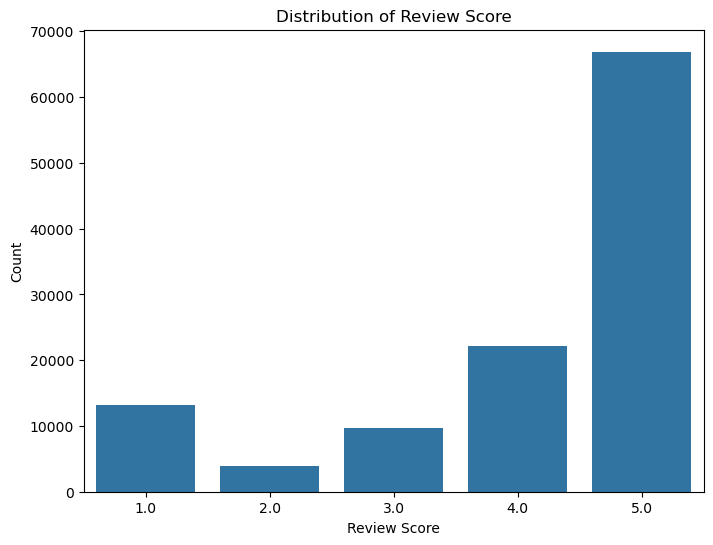

In [30]:
# Get counts of 'Satisfied' and 'Not Satisfied' reviews
review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
# plt.xticks(ticks=range(len(decoded_review_score)), labels=decoded_review_score)
plt.show()

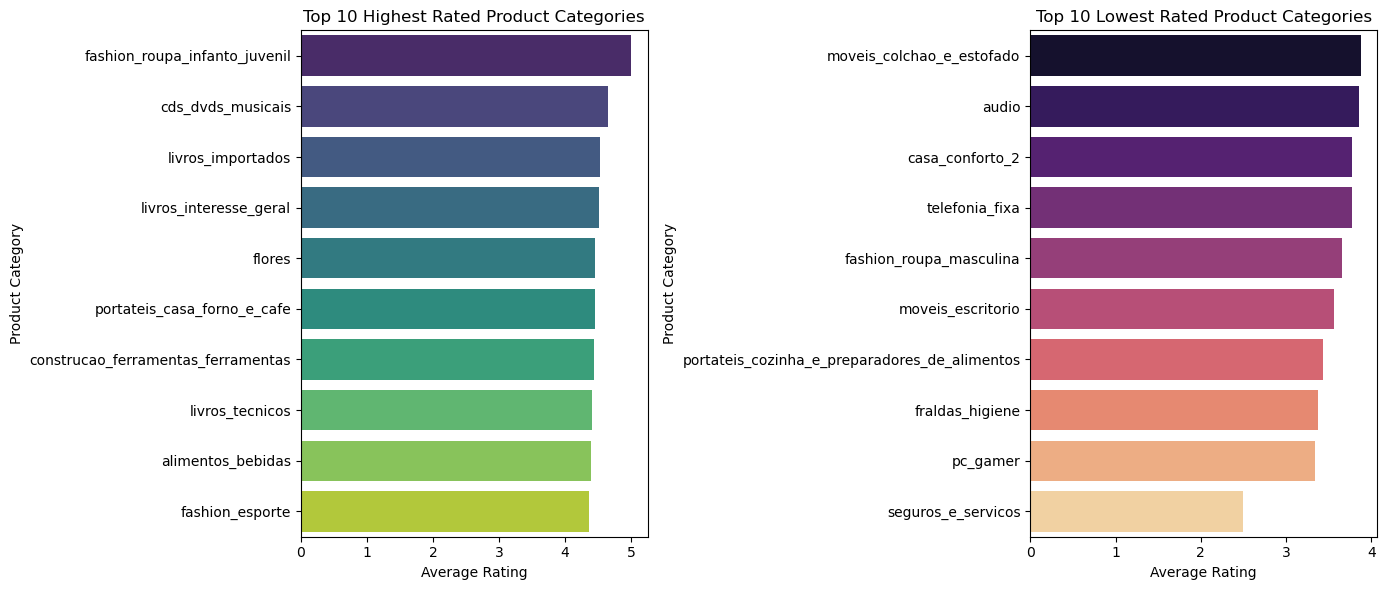

In [31]:
# Calculate the average rating for each product category
category_ratings = ecommerce_no_review_data_df.groupby('product_category_name')['review_score'].mean().reset_index()

# Sort the categories by rating
sorted_category_ratings = category_ratings.sort_values(by='review_score', ascending=False)

# Top 10 highest rated categories
top_categories = sorted_category_ratings.head(10)

# Bottom 10 lowest rated categories
bottom_categories = sorted_category_ratings.tail(10)

# Plotting
plt.figure(figsize=(14, 6))

# Highest Rated Categories
plt.subplot(1, 2, 1)
sns.barplot(x='review_score', y='product_category_name', data=top_categories, palette='viridis')
plt.title('Top 10 Highest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

# Lowest Rated Categories
plt.subplot(1, 2, 2)
sns.barplot(x='review_score', y='product_category_name', data=bottom_categories, palette='magma')
plt.title('Top 10 Lowest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

plt.tight_layout()
plt.show()

In [32]:
# Convert review_score to binary classification
ecommerce_no_review_data_df['review_score'] = ecommerce_no_review_data_df['review_score'].apply(lambda x: 1 if int(x) >= 4 else 0)

review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

In [33]:
print(review_score_distribution)

1    89038
0    26668
Name: review_score, dtype: int64


In [34]:
# Identify categorical features
categorical_features = [
    'order_status', 'payment_type', 'product_category_name', # 'review_score'
]

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    ecommerce_no_review_data_df[col] = le.fit_transform(ecommerce_no_review_data_df[col])
    label_encoders[col] = le

ecommerce_no_review_data_df.head(5)

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,1,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,1,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [35]:
ecommerce_no_review_data_df.describe(include='all')

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,115706.000000,115706,115706,115706,115706,115706,115706,115706.000000,115706.000000,115706.000000,...,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000,115706.000000
unique,NaN,95939,88272,80100,95649,445,91327,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,2017-08-14 20:43:31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,63,63,63,63,647,63,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,2016-09-19 23:11:33,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,2020-04-09 22:35:08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.999940,NaN,NaN,NaN,NaN,NaN,NaN,119.907518,19.981514,1.091283,...,171.810484,0.769519,37.202314,48.847190,782.217344,2.189437,2105.238760,30.237317,16.579062,23.063471
std,0.007778,NaN,NaN,NaN,NaN,NaN,NaN,182.679745,15.719324,0.686778,...,265.656142,0.421142,22.388419,9.952951,646.314263,1.711767,3772.079411,16.125211,13.418748,11.730328
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.850000,0.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,39.900000,13.080000,1.000000,...,60.850000,1.000000,14.000000,43.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000


In [36]:
# Identify numerical columns excluding encoded categorical columns
encoded_categorical_columns = [f for f in categorical_features]
numerical_columns = ecommerce_no_review_data_df.select_dtypes(include=['number']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in encoded_categorical_columns + ['review_score']]

# Print the identified numerical columns
print("Numerical columns identified:")
print(numerical_columns)

Numerical columns identified:
['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [37]:
# Decode categorical labels for other categorical features
decoded_categories = {}
for col in categorical_features:
    decoded_categories[col] = label_encoders[col].inverse_transform(ecommerce_no_review_data_df[col].unique())

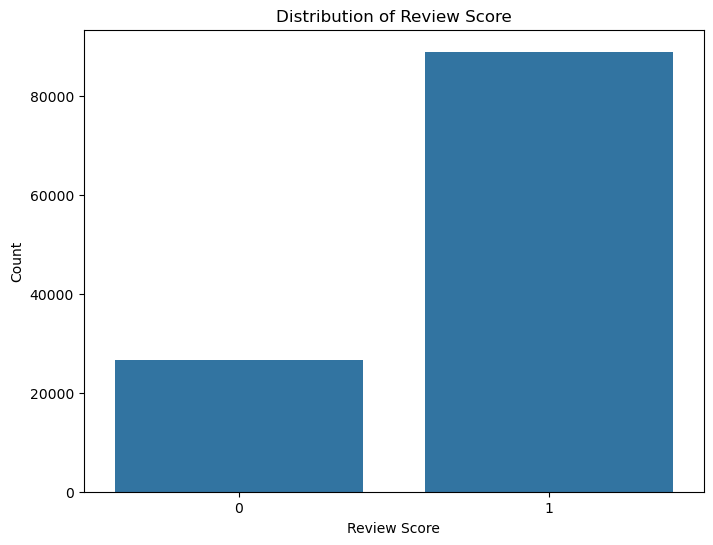

In [38]:
# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

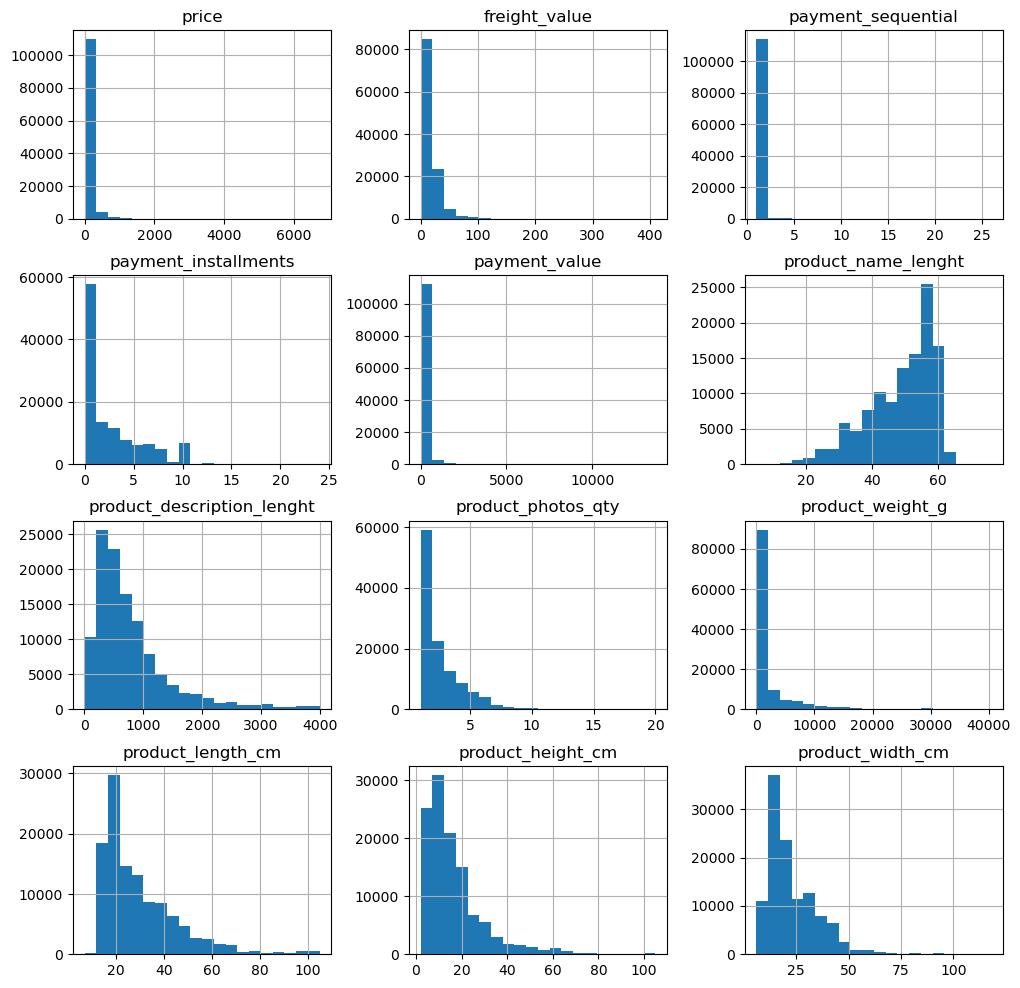

In [39]:
ecommerce_no_review_data_df[numerical_columns].hist(figsize=(12,12),bins=20)
plt.show()

In [40]:
# Calculate skewness
skewness = ecommerce_no_review_data_df[numerical_columns].apply(stats.skew)

# Interpretation
print("Skewness:")
print(skewness)

# Quick analysis
for col, skew_val in skewness.items():
    if abs(skew_val) > 1:
        print(f"{col} is highly skewed (Skewness: {skew_val})")
    elif abs(skew_val) > 0.5:
        print(f"{col} is moderately skewed (Skewness: {skew_val})")
    else:
        print(f"{col} is approximately symmetric (Skewness: {skew_val})")

Skewness:
price                          7.999792
freight_value                  5.569579
payment_sequential            14.992623
payment_installments           1.623686
payment_value                 14.410784
product_name_lenght           -0.927082
product_description_lenght     2.031436
product_photos_qty             1.921372
product_weight_g               3.589331
product_length_cm              1.736531
product_height_cm              2.240328
product_width_cm               1.703725
dtype: float64
price is highly skewed (Skewness: 7.99979187530175)
freight_value is highly skewed (Skewness: 5.569578603142233)
payment_sequential is highly skewed (Skewness: 14.992623214192616)
payment_installments is highly skewed (Skewness: 1.6236863086482782)
payment_value is highly skewed (Skewness: 14.410783546436766)
product_name_lenght is moderately skewed (Skewness: -0.9270819714378449)
product_description_lenght is highly skewed (Skewness: 2.031436079419098)
product_photos_qty is highly skewed (

The skewness values for the dataset's numerical features indicate the extent of asymmetry in their distributions. Notably, several features, including price, freight value, payment sequential, payment installments, and payment value, exhibit highly skewed distributions, suggesting a pronounced imbalance towards one tail of the distribution. Similarly, product description length, product photos quantity, product weight, length, height, and width show noticeable skewness, although to a lesser degree. Intriguingly, product name length displays moderate negative skewness, indicating a slight bias towards higher values, albeit in the opposite direction compared to other features. These observations underscore the non-normal distribution of many numerical features in the dataset, implying the potential need for transformations or specialized modeling techniques to address these skewness issues effectively.

There is a Severe Imbalance Between the Reviews

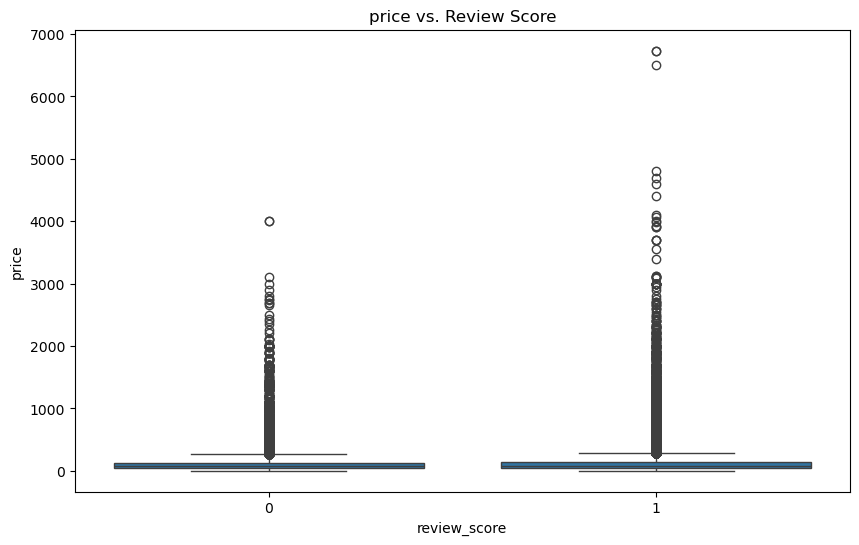

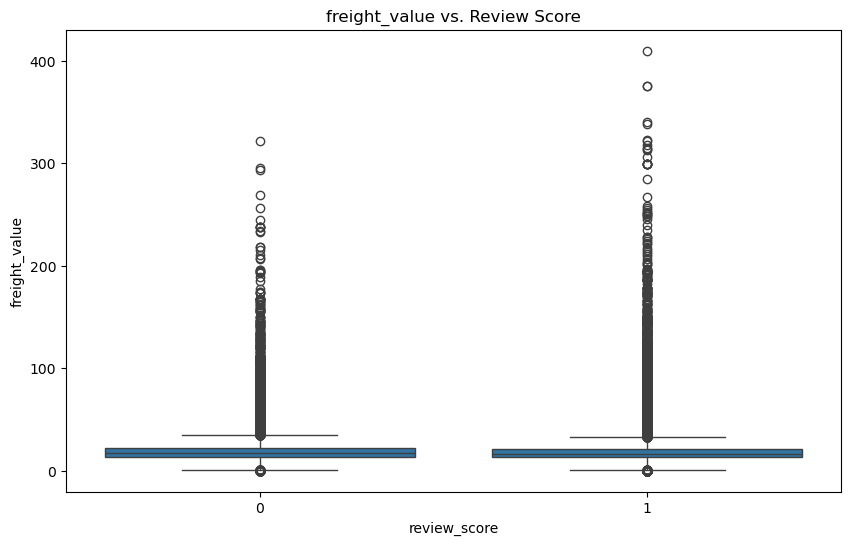

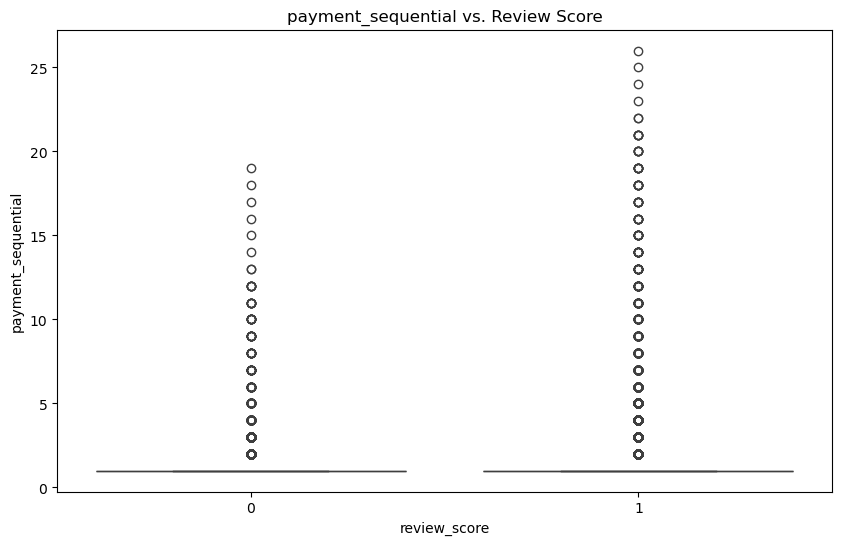

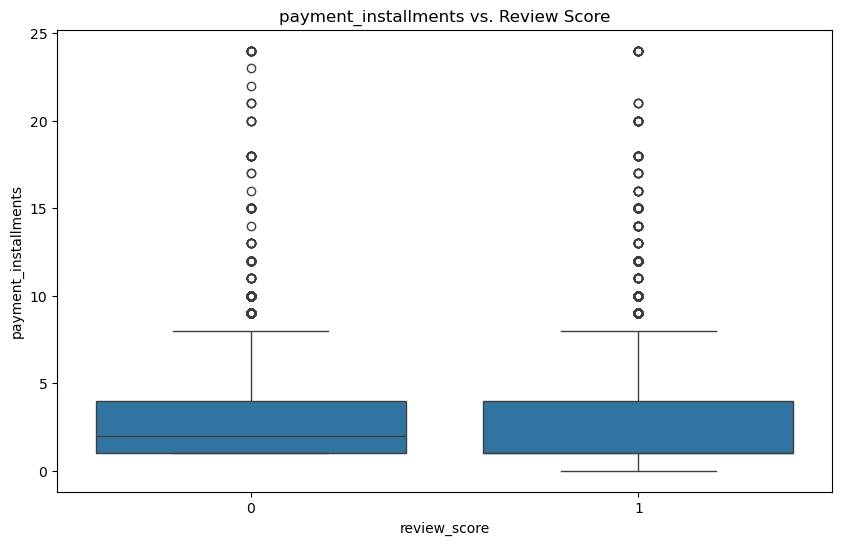

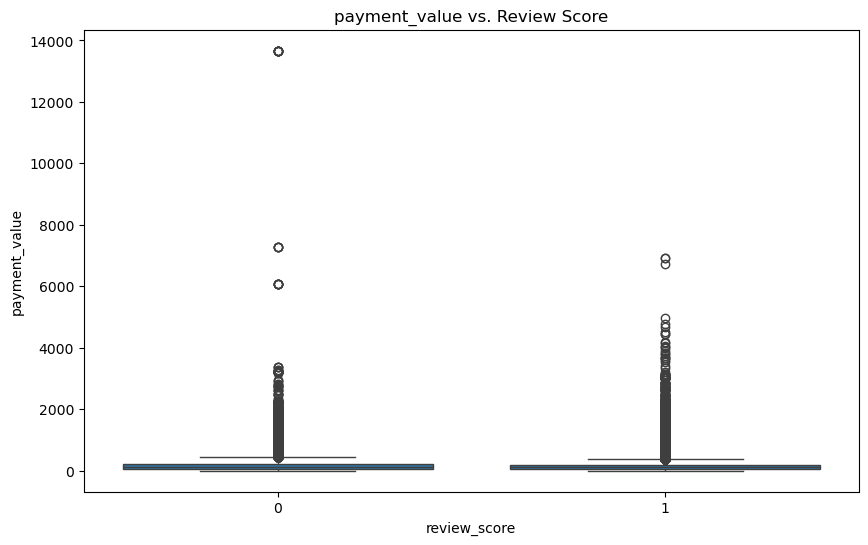

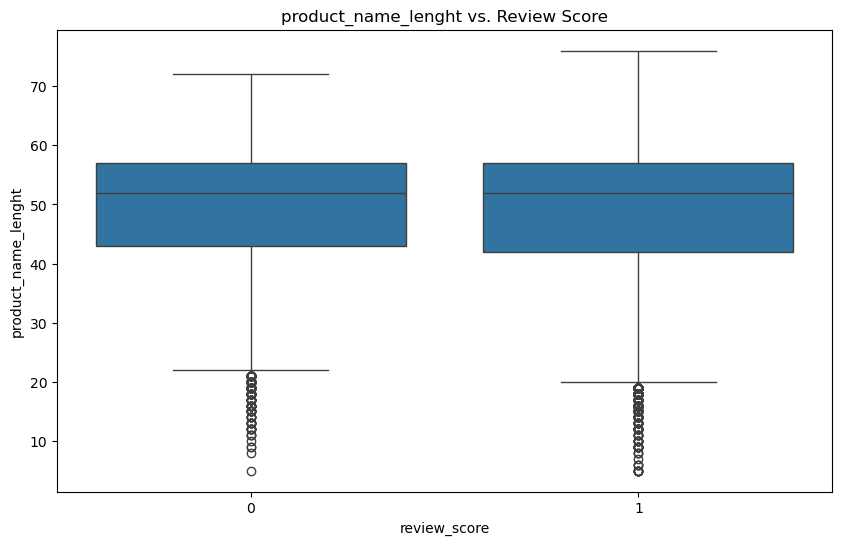

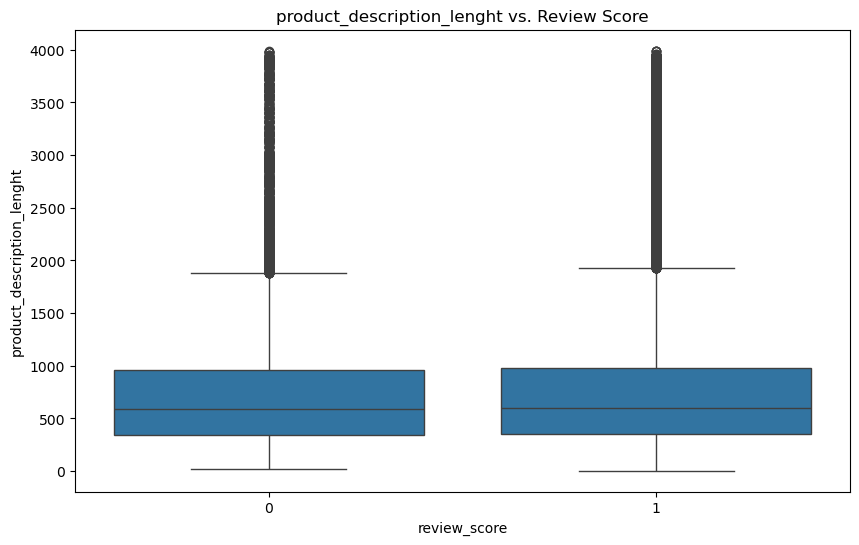

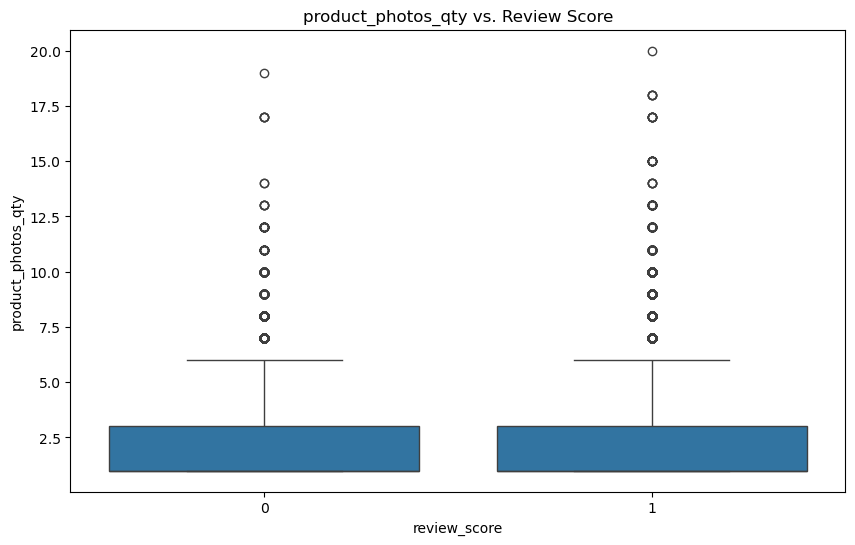

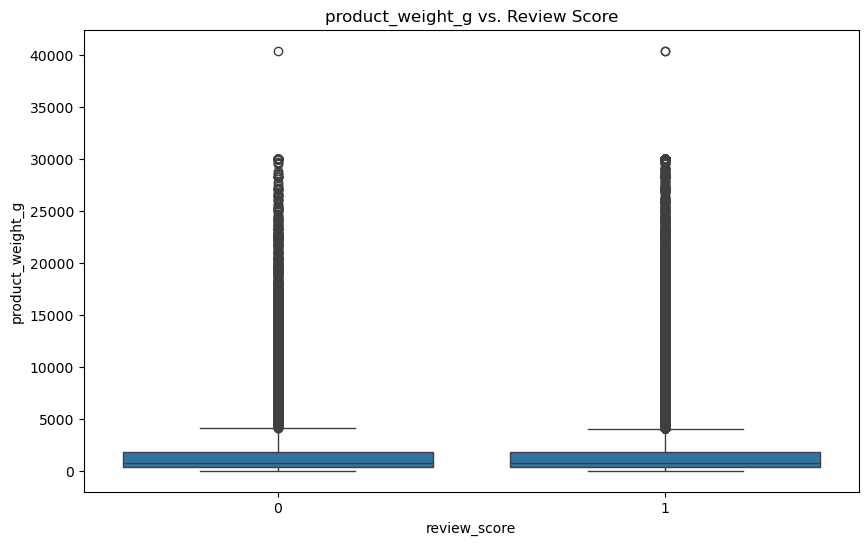

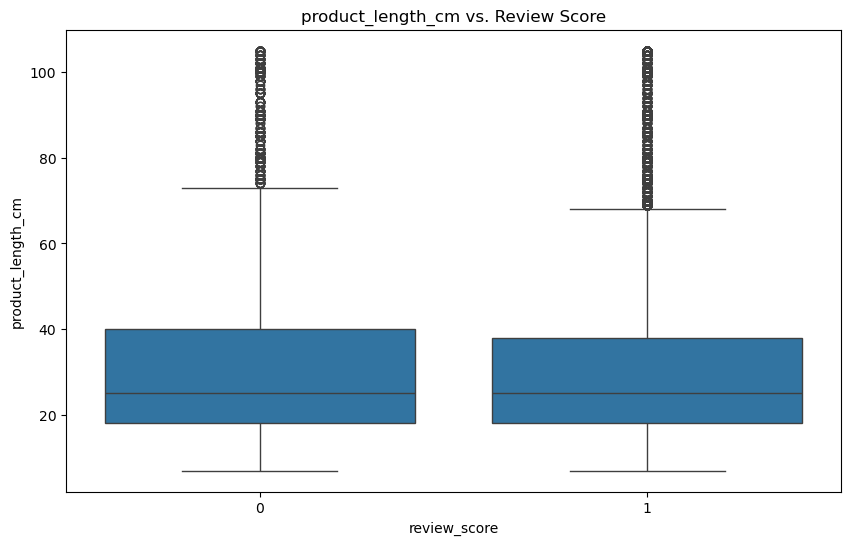

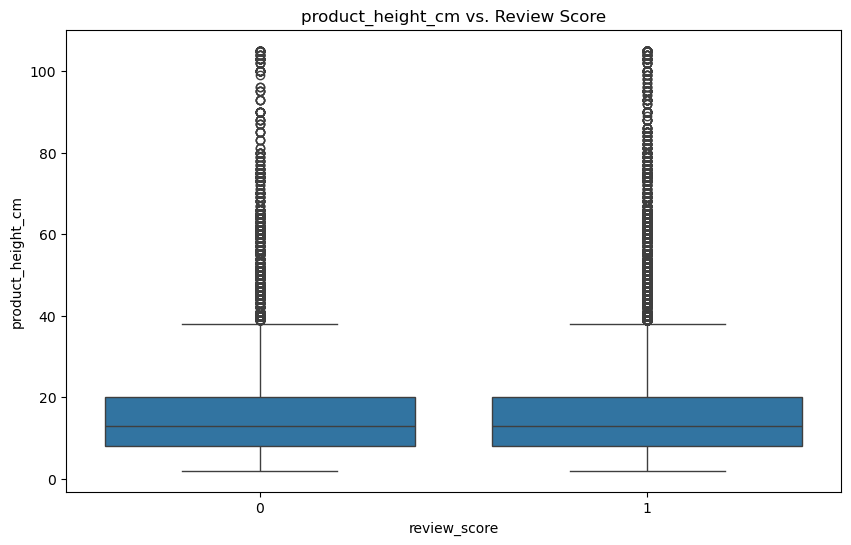

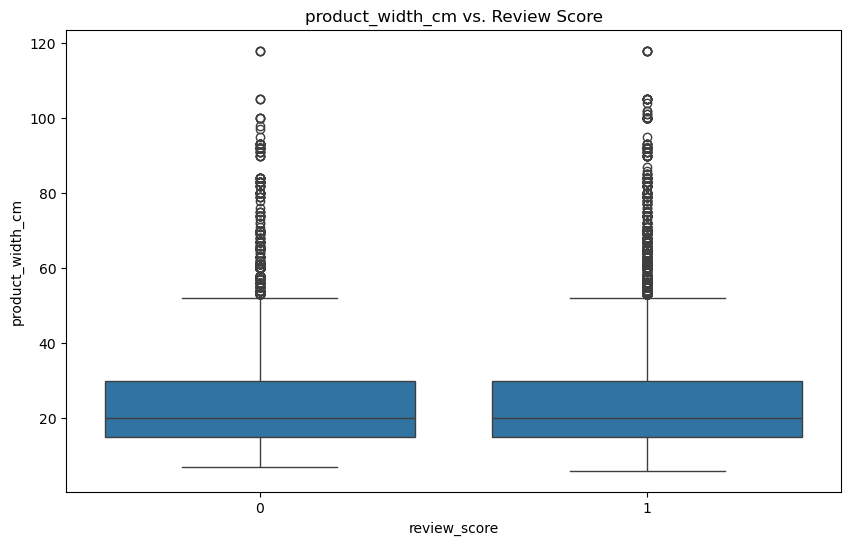

In [41]:
# Box plot for numerical features vs. review score
for feature in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='review_score', y=feature, data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    plt.show()

/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


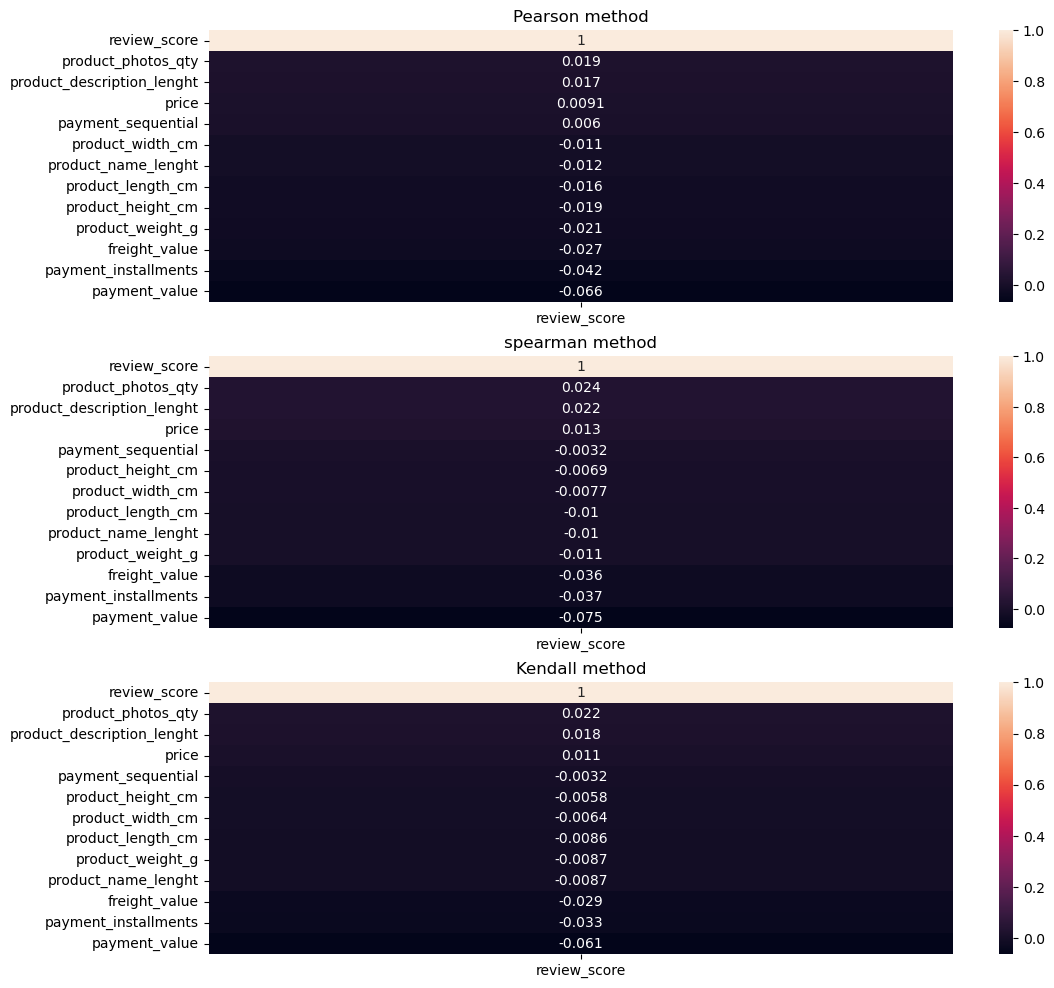

In [42]:
fig, ax = plt.subplots(3,1, figsize=(12, 12))
## Correlation coefficient using different methods
corr1 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('pearson')[['review_score']].sort_values(by='review_score', ascending=False)
corr2 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('spearman')[['review_score']].sort_values(by='review_score', ascending=False)
corr3 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('kendall')[['review_score']].sort_values(by='review_score', ascending=False)

#setting titles for each plot
ax[0].set_title('Pearson method')
ax[1].set_title('spearman method')
ax[2].set_title('Kendall method')
## Generating heatmaps of each methods
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.show()

It becomes apparent that non of the numerical feautres have a strong enough correlation to impact review_score

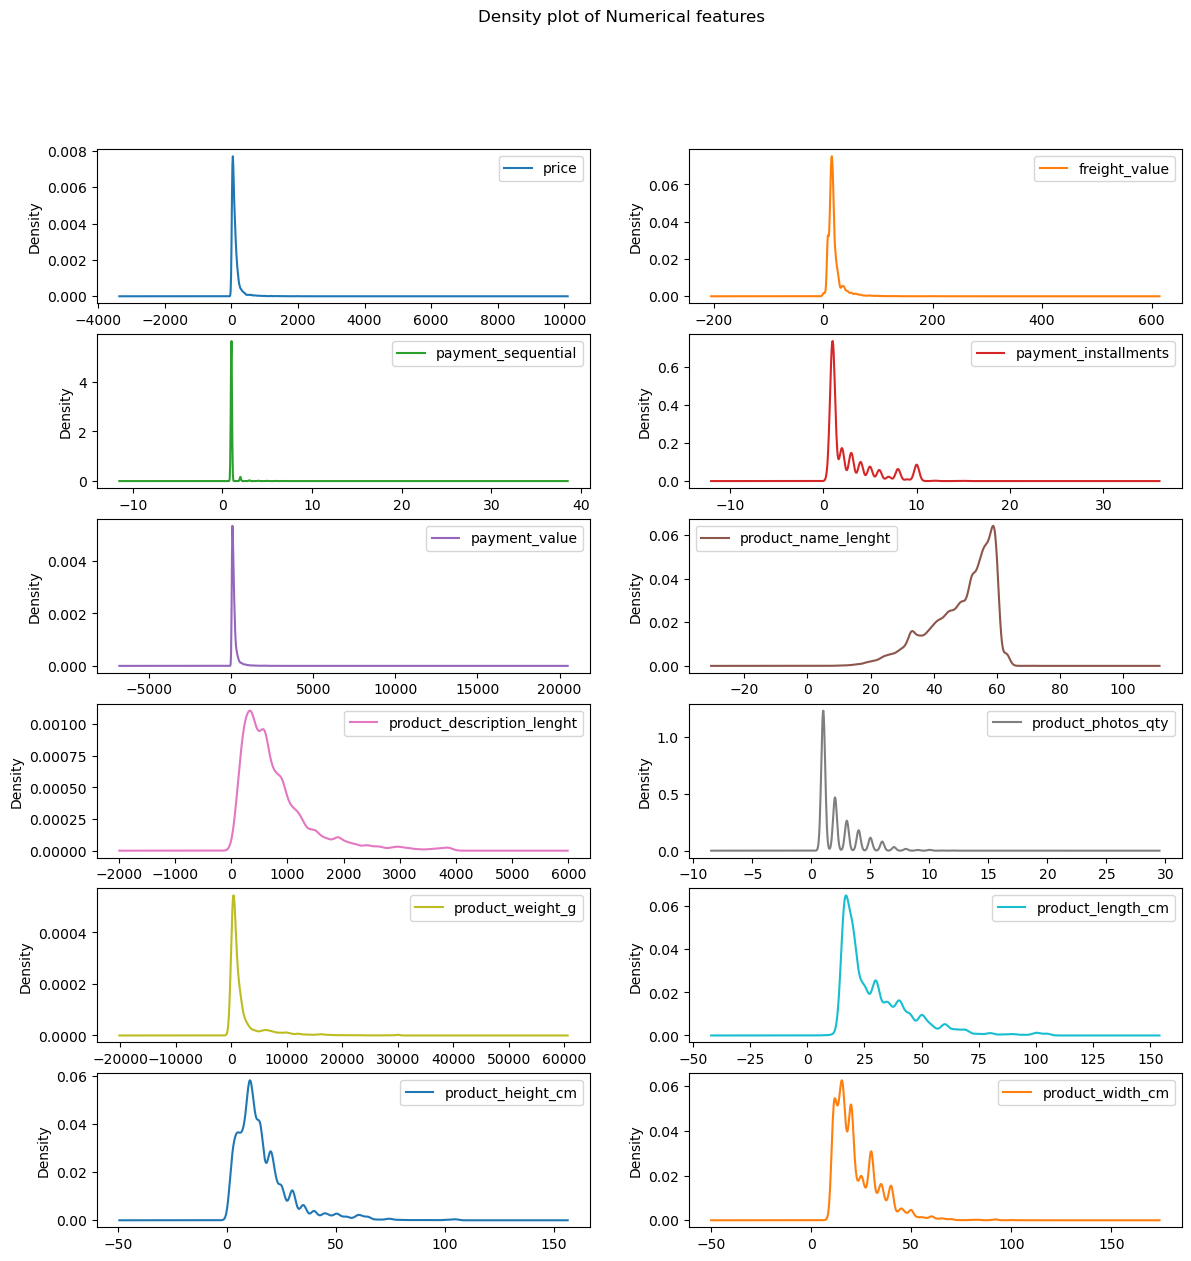

In [43]:
ecommerce_no_review_data_df[numerical_columns].plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

There is an Imbalance Not only in the Review Distribution but in the Numerical Feature Distributions as well

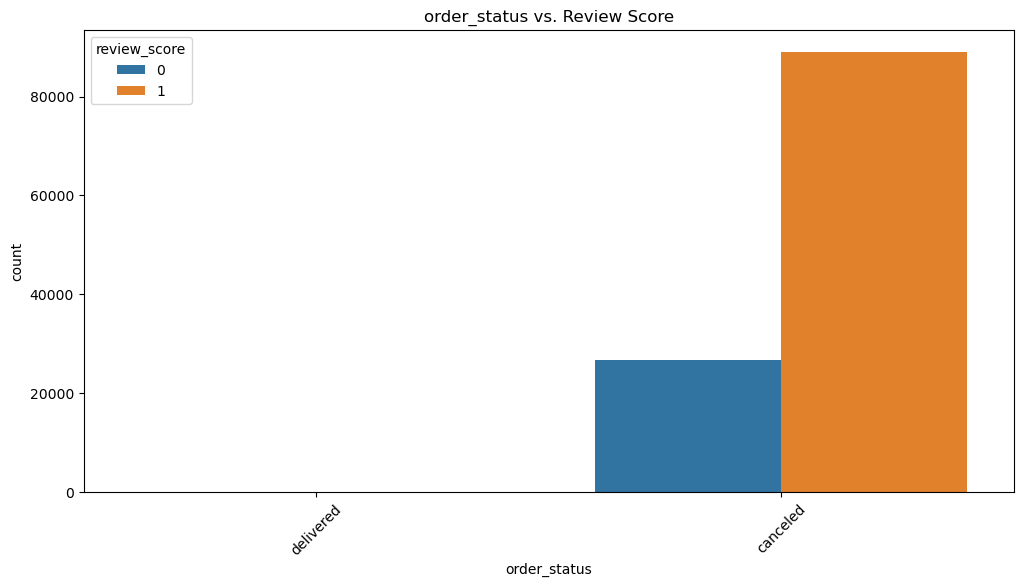

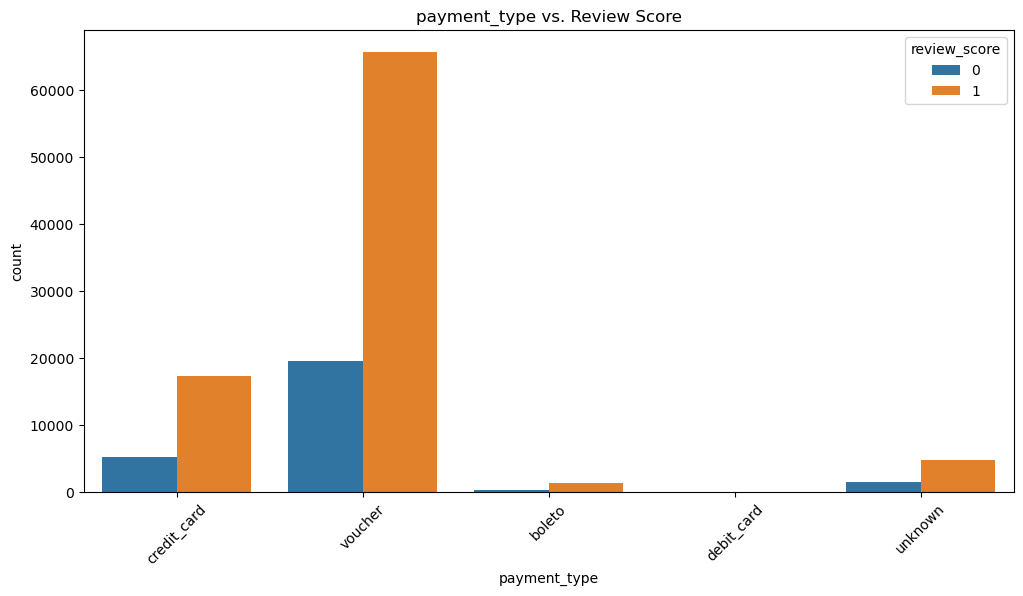

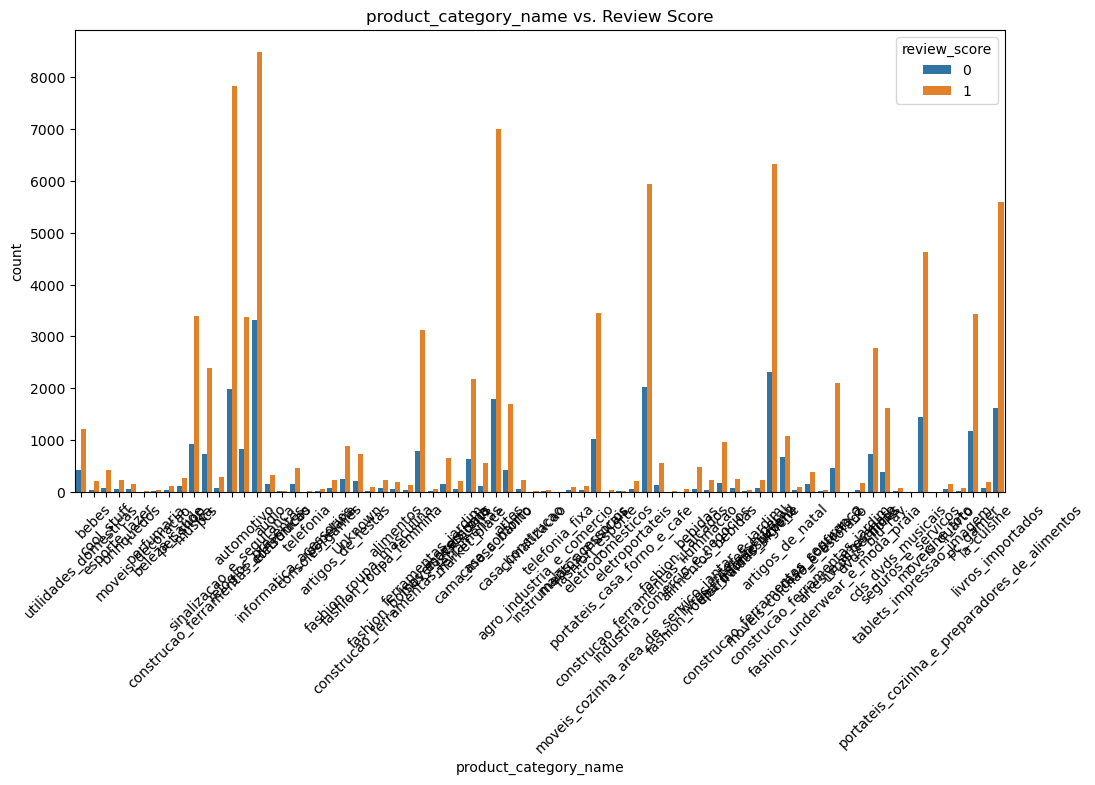

In [44]:
# Bar plot for categorical features vs. review score
for feature in categorical_features:
    if feature == 'review_score':
        continue
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='review_score', data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    # Decode x-axis labels for other categorical features
    plt.xticks(ticks=range(len(decoded_categories[feature])), labels=decoded_categories[feature], rotation=45)
    plt.show()

## Feature Engineering ##
### Add New Features ###
- 'delivery_time_days': The Number of Days it Took for an Order to be Delivered
- 'is_late': The Boolean Value of Whether or not the Order After the Anticipated Delivery Date
- 'seller_response_time': The Time in Seconds for the Seller to Start Working on an Order after Placed

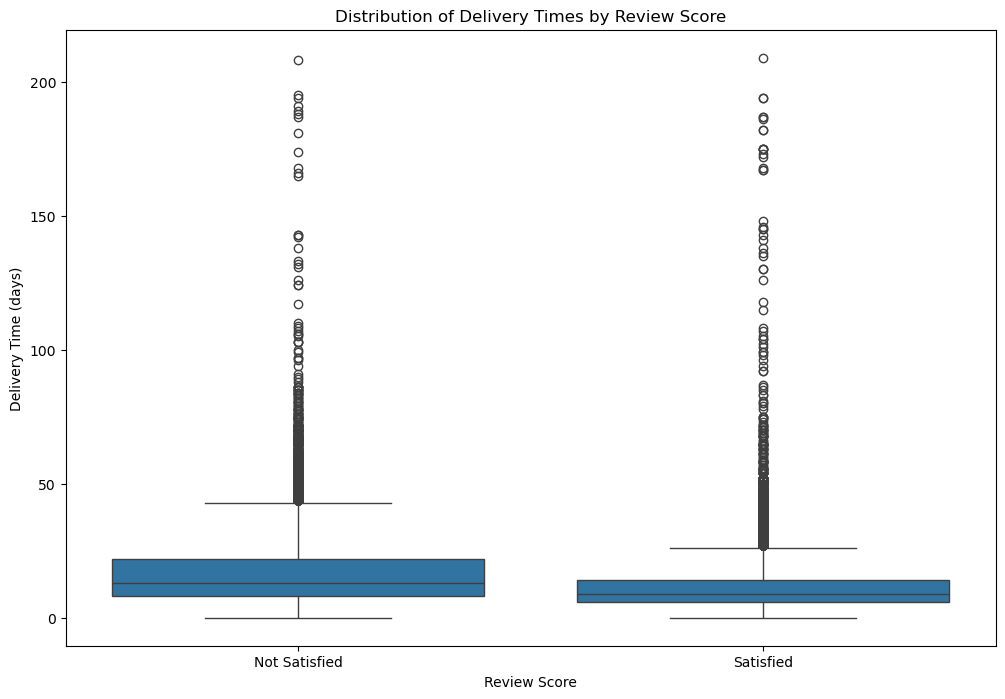

In [45]:
# Calculate the delivery time in days
ecommerce_no_review_data_df['delivery_time_days'] = (ecommerce_no_review_data_df['order_delivered_customer_date'] - ecommerce_no_review_data_df['order_purchase_timestamp']).dt.days

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='review_score', y='delivery_time_days', data=ecommerce_no_review_data_df)
plt.title('Distribution of Delivery Times by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.xticks(ticks=[0, 1], labels=['Not Satisfied', 'Satisfied'])
plt.show()

The box plots shows that there is a negative correlation between delivery time and review score. It means customers who get an order with longer delivery times tend to give bad reviews.

In [46]:
# Create is_late feature
ecommerce_no_review_data_df['is_late'] = (ecommerce_no_review_data_df['order_delivered_customer_date'] > ecommerce_no_review_data_df['order_estimated_delivery_date']).astype(int)

# Calculate seller response time in hours
ecommerce_no_review_data_df['seller_response_time'] = (ecommerce_no_review_data_df['order_approved_at'] - ecommerce_no_review_data_df['order_purchase_timestamp']).dt.total_seconds() / 3600

print(ecommerce_no_review_data_df[['is_late', 'seller_response_time']].head())

   is_late  seller_response_time
0        0              0.178333
1        0              0.178333
2        0              0.178333
3        0              1.595833
4        0              0.307778


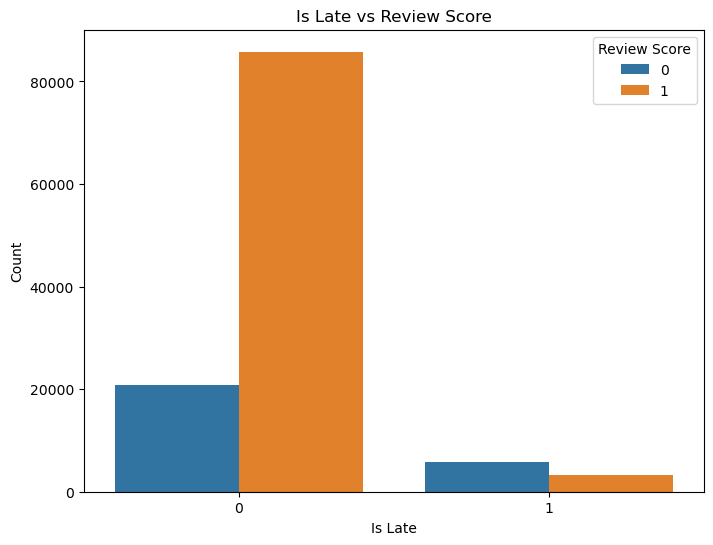

In [47]:
# Distribution of is_late
plt.figure(figsize=(8, 6))
sns.countplot(x='is_late', hue='review_score', data=ecommerce_no_review_data_df)
plt.title('Is Late vs Review Score')
plt.xlabel('Is Late')
plt.ylabel('Count')
plt.legend(title='Review Score')
plt.show()

Even with the Imbalance in 'Satisfied' (1) and 'Not Satsified' (0), If a Delivery is Late it is More Likely to have a negative review

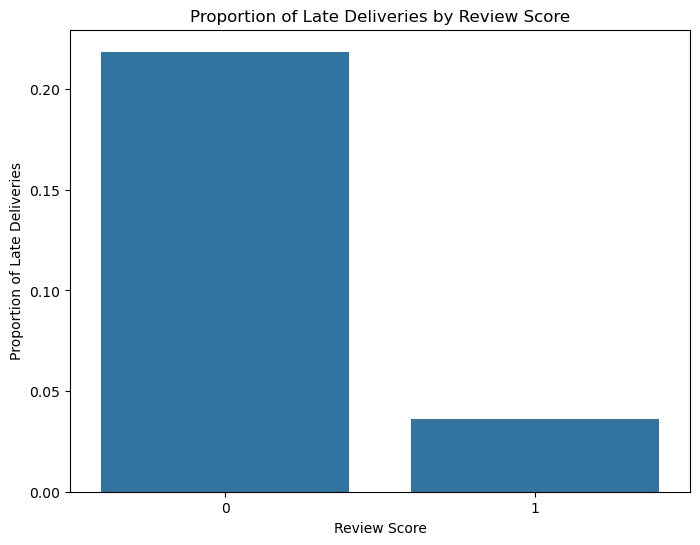

In [48]:
# Proportion of late deliveries by review score
late_review_prop = ecommerce_no_review_data_df.groupby('review_score')['is_late'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='review_score', y='is_late', data=late_review_prop)
plt.title('Proportion of Late Deliveries by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Proportion of Late Deliveries')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


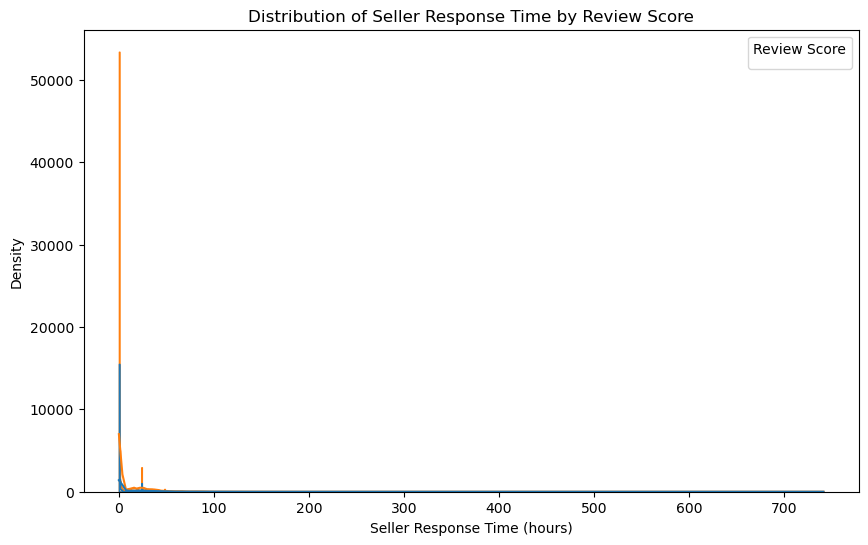

In [49]:
# Distribution of seller_response_time
plt.figure(figsize=(10, 6))
sns.histplot(ecommerce_no_review_data_df, x='seller_response_time', hue='review_score', kde=True, element='step')
plt.title('Distribution of Seller Response Time by Review Score')
plt.xlabel('Seller Response Time (hours)')
plt.ylabel('Density')
plt.legend(title='Review Score')
plt.show()

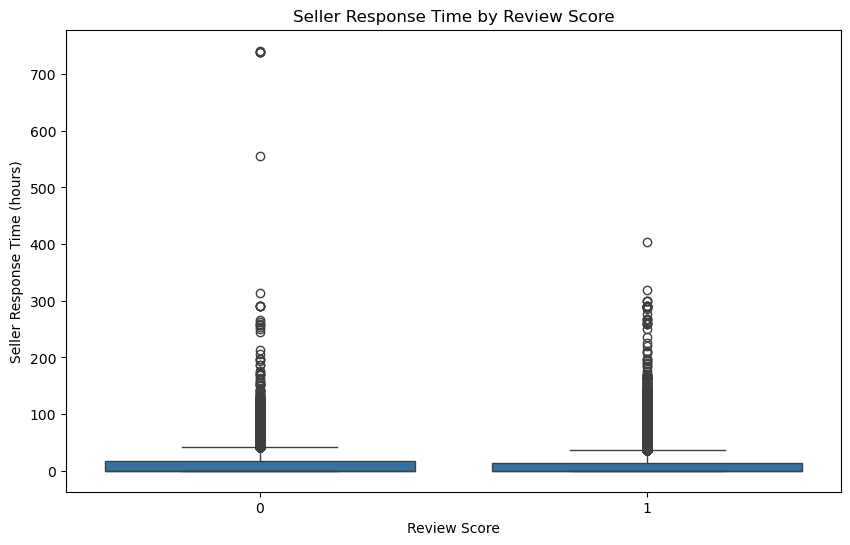

In [50]:
# Boxplot of seller_response_time by review_score
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='seller_response_time', data=ecommerce_no_review_data_df)
plt.title('Seller Response Time by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Seller Response Time (hours)')
plt.show()

In [51]:
# Drop Datetime Stamps
ecommerce_no_date_data_df = ecommerce_no_review_data_df.drop(columns=[col for col in datetime_columns if 'review' not in col])

ecommerce_no_date_data_df.head(5)

,order_status,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_time_days,is_late,seller_response_time
0,1,29.99,8.72,1.0,1,1.0,18.12,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
1,1,29.99,8.72,3.0,4,1.0,2.00,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
2,1,29.99,8.72,2.0,4,1.0,18.59,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
3,1,29.99,7.78,1.0,1,3.0,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,0,1.595833
4,1,29.99,7.78,1.0,1,1.0,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,0,0.307778


#### Drop Unrelated Features ####

In [52]:
features_to_drop = ['order_status','payment_type', 'payment_sequential', 'payment_installments', 'product_name_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_response_time']
ecommerce_feature_eng_df = ecommerce_no_date_data_df.drop(columns=features_to_drop)

ecommerce_feature_eng_df.head(5)

,price,freight_value,payment_value,review_score,product_category_name,product_description_lenght,product_photos_qty,delivery_time_days,is_late
0,29.99,8.72,18.12,1,73,268.0,4.0,8,0
1,29.99,8.72,2.00,1,73,268.0,4.0,8,0
2,29.99,8.72,18.59,1,73,268.0,4.0,8,0
3,29.99,7.78,37.77,1,73,268.0,4.0,2,0
4,29.99,7.78,37.77,1,73,268.0,4.0,5,0


In [53]:
numerical_feats = [col for col in ecommerce_feature_eng_df.columns if col not in categorical_features + ['review_score', 'is_late']]

numerical_feats

['price',
 'freight_value',
 'payment_value',
 'product_description_lenght',
 'product_photos_qty',
 'delivery_time_days']

In [54]:
## Feature Store ##
### Ingest Data into Feature Store ###
review_feature_group_name = 'review-feature-group' + strftime("%d-%H-%M-%S", gmtime())

current_time_sec = int(round(time()))

review_feature_group = FeatureGroup(name=review_feature_group_name, sagemaker_session=feature_store_session)

In [55]:
ecommerce_feature_eng_df.reset_index(drop=True, inplace=True)

In [56]:
# record identifier and event time feature names
# record_identifier_feature_name = "review"
event_time_feature_name = "EventTime"

# append EventTime feature
ecommerce_feature_eng_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(ecommerce_feature_eng_df), dtype="float64"
)

# load feature definitions to the feature group. SageMaker FeatureStore Python SDK will auto-detect the data schema based on input data.
review_feature_group.load_feature_definitions(data_frame=ecommerce_feature_eng_df)

[FeatureDefinition(feature_name='price', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='freight_value', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='payment_value', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='review_score', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='product_category_name', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='product_description_lenght', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='product_photos_qty', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='delivery_time_days', feature_type=<FeatureTypeEnum.INTE

## Perform Data Split ##

In [57]:
# Define features (X) and target variable (y)
X = ecommerce_feature_eng_df.drop(columns=['review_score'])
y = ecommerce_feature_eng_df['review_score']

# Split the data into training (40%), test (10%), validation (10%), and production (40%) datasets
X_train_val, X_production, y_train_val, y_production = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Production set shape:", X_production.shape, y_production.shape)

Train set shape: (52067, 9) (52067,)
Test set shape: (8678, 9) (8678,)
Validation set shape: (8678, 9) (8678,)
Production set shape: (46283, 9) (46283,)


In [58]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train[numerical_feats] = scaler.fit_transform(X_train[numerical_feats])

# Transform the validation and test data using the same scaler
X_val[numerical_feats] = scaler.transform(X_val[numerical_feats])
X_test[numerical_feats] = scaler.transform(X_test[numerical_feats])
X_production[numerical_feats] = scaler.transform(X_production[numerical_feats])

# Check the result
print(X_train.head())

          price  freight_value  payment_value  product_category_name  \
40428 -0.488493      -0.214092      -0.465400                     54   
98099  0.752339      -0.037177       1.431187                     63   
81348 -0.376227      -0.372051      -0.397243                     13   
10529 -0.221802      -0.442185      -0.294953                     31   
69561 -0.382029      -0.202087       0.331144                     67   

       product_description_lenght  product_photos_qty  delivery_time_days  \
40428                    0.280233            1.643232            0.105642   
98099                   -0.373561           -0.694375            0.949970   
81348                   -0.671865           -0.109973           -0.527604   
10529                   -0.344195            0.474429           -0.105440   
69561                   -0.647135            1.058831            0.633347   

       is_late     EventTime  
40428        0  1.718242e+09  
98099        0  1.718242e+09  
81348      

In [59]:
# Merge features and target variable for training and validation sets
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)

In [60]:
# Upload Split Data into S3
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/data/train".format(prefix))

validation_file = "validation_data.csv"
val_data.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/data/validation".format(prefix))

batch_file = "batch_data.csv"
X_test.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/data/batch".format(prefix))

prod_file = "prod_data.csv"
X_production.to_csv(prod_file, index=False, header=False)
sess.upload_data(prod_file, key_prefix="{}/data/prod".format(prefix))

's3://sagemaker-us-east-1-757088774357/olist_review_score/data/prod/prod_data.csv'

## Benchmark XGBoost Model ##

In [93]:
benchmark_job_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: ", benchmark_job_name)

benchmark_endpoint_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint name: ", benchmark_endpoint_name)

benchmark_output_location = "s3://{}/{}/output/{}".format(bucket, prefix, benchmark_job_name)
print("S3 location for model", benchmark_output_location)

image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

eval_metrics = 'auc,aucpr,f1,precision,recall'

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=benchmark_output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    objective= 'binary:logistic',  # Binary classification
    max_depth= 5,  # Maximum depth of each tree
    eta= 0.2,  # Learning rate
    gamma= 4,  # Minimum loss reduction required to make a further partition on a leaf node
    subsample= 0.8,  # Subsample ratio of the training instances
    colsample_bytree= 0.8,  # Subsample ratio of columns when constructing each tree
    eval_metric= eval_metrics,  # Evaluation metric
    alpha= 0.1,  # L1 regularization term
    num_round=100
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=benchmark_job_name, logs=True)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: benchmark-xgboost-review-score-prediction-2024-06-13-02-40-07


Model name:  benchmark-xgboost-review-score-prediction-2024-06-13-02-40-07
Endpoint name:  benchmark-xgboost-review-score-prediction-2024-06-13-02-40-07
S3 location for model s3://sagemaker-us-east-1-757088774357/olist_review_score/output/benchmark-xgboost-review-score-prediction-2024-06-13-02-40-07
2024-06-13 02:40:07 Starting - Starting the training job...
2024-06-13 02:40:23 Starting - Preparing the instances for training...
2024-06-13 02:40:53 Downloading - Downloading input data...
2024-06-13 02:41:23 Downloading - Downloading the training image...
2024-06-13 02:41:59 Training - Training image download completed. Training in progress...[2024-06-13 02:42:10.312 ip-10-2-112-149.ec2.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-13 02:42:10.334 ip-10-2-112-149.ec2.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-13:02:42:10:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-13:02:42:10:INFO] Failed to p

### Benchmark Results on Batch Data ###

In [94]:
# Create the transformer object
benchmark_transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# Specify the S3 URI of the test data
test_data_s3_uri = "s3://{}/{}/data/batch/{}".format(bucket, prefix, batch_file)

benchmark_transformer.transform(
    test_data_s3_uri,
    split_type="Line",
    content_type="text/csv",
)

# Wait for the job to complete
benchmark_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-13-02-42-49-320
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-13-02-42-50-023


................................[2024-06-13:02:48:12:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-13:02:48:12:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-13:02:48:12:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-13 02:48:12 +0000] [19] [INFO] Starting gun

In [95]:
def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    print(output_bucket + output_prefix)
    s3_client.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [96]:
batch_out_df = get_csv_output_from_s3(benchmark_transformer.output_path, batch_file)
batch_out_df.head(5)

sagemaker-us-east-1-757088774357sagemaker-xgboost-2024-06-13-02-42-50-023/batch_data.csv.out


,0
0,0.867868
1,0.833611
2,0.370835
3,0.753490
4,0.655089


### Batch Benchmark Model Metrics  ###

In [97]:
def convert_probabilities_to_binary(probabilities, threshold=0.5):
    # Convert probabilities to binary predictions
    binary_predictions = (probabilities >= threshold).astype(int)
    return binary_predictions

def calculate_metrics(y_true, y_prob):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_prob)
    precision = precision_score(y_true, y_prob)
    recall = recall_score(y_true, y_prob)
    f1 = f1_score(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    return accuracy, precision, recall, f1, roc_auc

def print_metrics(accuracy, precision, recall, f1, roc_auc):
    metrics_string = f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}"
    print(metrics_string)


In [98]:
review_prob_threshold = 0.8

In [99]:
y_prob = convert_probabilities_to_binary(batch_out_df[0], review_prob_threshold)

accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch = calculate_metrics(y_test, y_prob)

print_metrics(accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch)

Accuracy: 0.6798, Precision: 0.8605, Recall: 0.6978, F1 Score: 0.7706, ROC AUC: 0.6585


The accuracy metric, which measures the overall correctness of the model's predictions, may appear deceptively high in the presence of class imbalance. In scenarios where the majority class dominates, a model could achieve high accuracy by simply predicting the majority class for every instance, without effectively capturing the nuances of the minority class.

Precision, recall, and F1 score are metrics that focus specifically on the performance of the minority class, making them more informative in imbalanced datasets. Precision reflects the proportion of true positive predictions among all positive predictions made by the model. In this case, the precision of 0.8141 suggests that the model correctly identifies a substantial portion of positive instances but may also produce false positives.

Recall, on the other hand, measures the proportion of true positive predictions among all actual positive instances in the dataset. The high recall value of 0.9611 indicates that the model effectively captures the majority of positive instances present in the data.

The F1 score, which represents the harmonic mean of precision and recall, provides a balanced assessment of the model's ability to correctly identify positive instances while minimizing false positives. The F1 score of 0.8815 suggests that the model achieves a good balance between precision and recall, considering the imbalanced nature of the dataset.

ROC AUC (Receiver Operating Characteristic Area Under the Curve) measures the model's ability to distinguish between the positive and negative classes across various threshold values. However, in imbalanced datasets, ROC AUC may not fully capture the performance of the minority class, as it can be dominated by the majority class. Therefore, the ROC AUC value of 0.6391 should be interpreted with caution, considering the class imbalance.

### Upload Benchmark Model to Sagemaker Model Registry ###

#### Setup Model Group ####

In [68]:
try:
    response = sm.create_model_package_group(
        ModelPackageGroupName=benchmark_endpoint_name,
        ModelPackageGroupDescription='This package group contains XGBoost models used for predicting product review scores on the Olist platform.'
    )
    print(f"Model package group created: {response['ModelPackageGroupArn']}")
except sm.exceptions.ResourceInUse:
    print(f"Model package group '{benchmark_endpoint_namee}' already exists.")

Model package group created: arn:aws:sagemaker:us-east-1:757088774357:model-package-group/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00


In [69]:
create_model_package_input_dict = {
    "ModelPackageGroupName": benchmark_endpoint_name,
    "ModelPackageDescription": "This package group contains models used for predicting product review scores on the Olist platform.",
    "ModelApprovalStatus": "PendingManualApproval",
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": image,
                "ModelDataUrl": f"{benchmark_output_location}/{benchmark_job_name}/output/model.tar.gz",
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"]
    }
}

create_model_package_response = sm.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print(f"Model package created: {model_package_arn}")

Model package created: arn:aws:sagemaker:us-east-1:757088774357:model-package/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00/1


In [70]:
response = sm.describe_model_package(
    ModelPackageName=model_package_arn
)

print(response)

{'ModelPackageGroupName': 'benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00', 'ModelPackageVersion': 1, 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:757088774357:model-package/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00/1', 'ModelPackageDescription': 'This package group contains models used for predicting product review scores on the Olist platform.', 'CreationTime': datetime.datetime(2024, 6, 13, 1, 30, 49, 719000, tzinfo=tzlocal()), 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1', 'ImageDigest': 'sha256:9aaafe236a367412ead0e5cd4704789ed2f4901e6a98f61e861ed61853748720', 'ModelDataUrl': 's3://sagemaker-us-east-1-757088774357/olist_review_score/output/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00/output/model.tar.gz'}], 'SupportedContentTypes': ['text/csv'], 'SupportedResponseMIMETypes': ['text/csv']}, 

### Upload Benchmark Model Card ###

In [73]:
model_card_name = "ReviewScoreXGBoostModelCardv3"

input_features = X_val.columns

# Define hyperparameters used for training
hyperparameters = [
    {"name": "objective", "value": "binary:logistic"},
    {"name": "max_depth", "value": "5"},
    {"name": "eta", "value": "0.2"},
    {"name": "gamma", "value": "4"},
    {"name": "colsample_bytree", "value": "0.8"},
    {"name": "eval_metric", "value": eval_metrics},
    {"name": "alpha", "value": "0.1"},
    {"name": "num_round", "value": "100"}
]

content = {
  "model_overview": {
    "algorithm_type": "XGBoost",
    "problem_type": "Binary classification",
    "model_owner": "Se'Lina Lasher & Prachi Khanna"
  },
  "model_package_details": {
    "model_package_arn": model_package_arn
  },
  "training_details": {
    "objective_function": {
        "function": "Maximize",
        "notes": "The model aims to maximize the likelihood of correct review score prediction."
    },
    "training_observations": "The model was trained on a dataset consisting of various factors such shipping information, seller information and product information",
    "training_job_details": {
        "hyper_parameters": hyperparameters
    }
  },
  "intended_uses": {
    "purpose_of_model": "To predict whether a product will have a satisfactory review (>4 stars)"
  },
  "additional_information": {
    "ethical_considerations": "This model may exhibit biases related to price, delivery times, and seller resources, potentially affecting fairness in predicting review scores. Regular monitoring and updates are recommended to mitigate these biases"
  }
}

content_string = json.dumps(content)

model_card_status = "Draft"

model_card = sm.create_model_card(ModelCardName=model_card_name, Content=content_string, ModelCardStatus=model_card_status)

In [74]:
response = sm.describe_model_card(ModelCardName=model_card_name)
print(response)

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:757088774357:model-card/ReviewScoreXGBoostModelCardv3', 'ModelCardName': 'ReviewScoreXGBoostModelCardv3', 'ModelCardVersion': 1, 'Content': '{"model_overview": {"algorithm_type": "XGBoost", "problem_type": "Binary classification", "model_owner": "Se\'Lina Lasher & Prachi Khanna"}, "model_package_details": {"model_package_arn": "arn:aws:sagemaker:us-east-1:757088774357:model-package/benchmark-xgboost-review-score-prediction-2024-06-13-01-22-00/1"}, "training_details": {"objective_function": {"function": "Maximize", "notes": "The model aims to maximize the likelihood of correct review score prediction."}, "training_observations": "The model was trained on a dataset consisting of various factors such shipping information, seller information and product information", "training_job_details": {"hyper_parameters": [{"name": "objective", "value": "binary:logistic"}, {"name": "max_depth", "value": "5"}, {"name": "eta", "value": "0.2"}, {"name": "gam

## Model Optimization ##

In [76]:
optimized_job_name = 'optimized-xgb-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: ", optimized_job_name)

optimized_endpoint_name = 'optimized-xgb-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint name: ", optimized_endpoint_name)

optimized_output_location = "s3://{}/{}/output/{}".format(bucket, prefix, optimized_job_name)
print("S3 location for model", optimized_output_location)

xgb_image = retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

# Set KNN parameters
xgb_estimator = sagemaker.estimator.Estimator(
    xgb_image,
    role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=optimized_output_location,
    input_mode="File",
    sagemaker_session=sess
)

# Set hyperparameters
xgb_estimator.set_hyperparameters(
    objective= 'binary:logistic',  # Binary classification
    max_depth= 10,  # Maximum depth of each tree
    eta= 0.1,  # Learning rate
    gamma= 4,  # Minimum loss reduction required to make a further partition on a leaf node
    subsample= 0.8,  # Subsample ratio of the training instances
    colsample_bytree= 0.8,  # Subsample ratio of columns when constructing each tree
    eval_metric= eval_metrics,  # Evaluation metric
    alpha= 0.1,  # L1 regularization term
    num_round=100
)


train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

# Start the training job
xgb_estimator.fit({'train': train_data, 'validation': validation_data})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-06-13-02-13-02-162


Model name:  optimized-xgb-review-score-prediction-2024-06-13-02-13-02
Endpoint name:  optimized-xgb-review-score-prediction-2024-06-13-02-13-02
S3 location for model s3://sagemaker-us-east-1-757088774357/olist_review_score/output/optimized-xgb-review-score-prediction-2024-06-13-02-13-02
2024-06-13 02:13:02 Starting - Starting the training job...
2024-06-13 02:13:17 Starting - Preparing the instances for training...
2024-06-13 02:13:44 Downloading - Downloading input data...
2024-06-13 02:14:09 Downloading - Downloading the training image...
2024-06-13 02:14:50 Training - Training image download completed. Training in progress..[2024-06-13 02:15:01.996 ip-10-2-82-134.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-13 02:15:02.018 ip-10-2-82-134.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-13:02:15:02:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-13:02:15:02:INFO] Failed to parse hyperparam

### Optimized XGB Model Results on Batch Data ###

In [77]:
# Create the transformer object
xgb_transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

xgb_transformer.transform(
    test_data_s3_uri,
    split_type="Line",
    content_type="text/csv",
)

# Wait for the job to complete
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-13-02-15-44-733
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-13-02-15-45-443


...................................[2024-06-13:02:21:37:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-13:02:21:37:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-13:02:21:37:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-13 02:21:37 +0000] [19] [INFO] Starting 

In [78]:
xgb_out_df = get_csv_output_from_s3(xgb_transformer.output_path, batch_file)
xgb_out_df.head(5)

sagemaker-us-east-1-757088774357sagemaker-xgboost-2024-06-13-02-15-45-443/batch_data.csv.out


,0
0,0.911194
1,0.823535
2,0.187804
3,0.721893
4,0.821056


### Calculate Metrics ###

In [81]:
predicted_labels = convert_probabilities_to_binary(xgb_out_df[0], review_prob_threshold)

xgb_accuracy_batch, xgb_precision_batch, xgb_recall_batch, xgb_f1_batch, xgb_roc_auc_batch = calculate_metrics(y_test, predicted_labels)

print_metrics(xgb_accuracy_batch, xgb_precision_batch, xgb_recall_batch, xgb_f1_batch, xgb_roc_auc_batch)

Accuracy: 0.6885, Precision: 0.8654, Recall: 0.7057, F1 Score: 0.7774, ROC AUC: 0.6682


### Optimized Model vs. Benchmark Model Evalution ###

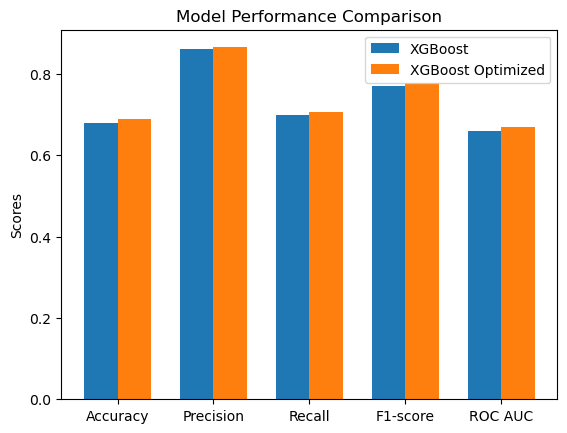

In [100]:
# Define the evaluation metrics for XGBoost and KNN
xgb_metrics = {
    "Accuracy": accuracy_batch,
    "Precision": precision_batch,
    "Recall": recall_batch,
    "F1-score": f1_batch,
    "ROC AUC":roc_auc_batch
}

xgb_opt_metrics = {
    "Accuracy": xgb_accuracy_batch,
    "Precision": xgb_precision_batch,
    "Recall": xgb_recall_batch,
    "F1-score": xgb_f1_batch,
    "ROC AUC": xgb_roc_auc_batch
}

# Plot the metrics
metrics = list(xgb_metrics.keys())
xgb_values = list(xgb_metrics.values())
knn_values = list(xgb_opt_metrics.values())

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, xgb_values, width, label='XGBoost')
rects2 = ax.bar([p + width for p in x], knn_values, width, label='XGBoost Optimized')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

In [101]:
# Dump the metrics to JSON
xgb_metrics_json = json.dumps(xgb_metrics, indent=4)
xgb_opt_metrics_json = json.dumps(xgb_opt_metrics, indent=4)

# Print or save the JSON strings
print("XGBoost Metrics:")
print(xgb_metrics_json)

print("\nXGBoost Optimized Metrics:")
print(xgb_opt_metrics_json)

XGBoost Metrics:
{
    "Accuracy": 0.6797649227932704,
    "Precision": 0.8604608294930876,
    "Recall": 0.6977578475336322,
    "F1-score": 0.7706149401568304,
    "ROC AUC": 0.6584865696420676
}

XGBoost Optimized Metrics:
{
    "Accuracy": 0.6885227010831989,
    "Precision": 0.8654445462878093,
    "Recall": 0.7056801195814649,
    "F1-score": 0.7774392754219844,
    "ROC AUC": 0.6682324139154809
}


The metrics between the two XGBoost models reveals a consistent performance enhancement in the optimized model across all key measures. The accuracy improved from 0.6798 to 0.6885, indicating that the optimized model has a higher overall rate of correct classifications. Precision, which reflects the proportion of true positives among the predicted positives, increased from 0.8605 to 0.8654, suggesting that the optimized model produces slightly more reliable positive predictions. Recall, measuring the ability to identify all relevant instances, increased from 0.6978 to 0.7057, demonstrating an improved capacity of the optimized model to capture true positives. The F1-score, a harmonic mean of precision and recall, rose from 0.7706 to 0.7774, highlighting a better balance between precision and recall in the optimized model. Lastly, the ROC AUC, which evaluates the trade-off between true positive and false positive rates, increased from 0.6585 to 0.6682, indicating enhanced discriminative ability of the optimized model. Overall, these improvements signify that the optimizations have positively impacted the model’s performance, making it more effective and reliable in its predictions.

We will be moving forward with Optimized XGBoost as the Model to Deploy.

### Upload Optimized Model to the Model Registry ###

In [102]:
try:
    response = sm.create_model_package_group(
        ModelPackageGroupName=optimized_endpoint_name,
        ModelPackageGroupDescription='This package group contains XGBoost models used for predicting product review scores on the Olist platform.'
    )
    print(f"Model package group created: {response['ModelPackageGroupArn']}")
except Exception:
    print(f"Model package group '{optimized_endpoint_name}' already exists.")

Model package group created: arn:aws:sagemaker:us-east-1:757088774357:model-package-group/optimized-xgb-review-score-prediction-2024-06-13-02-13-02


In [105]:
create_model_package_input_dict = {
    "ModelPackageGroupName": optimized_endpoint_name,
    "ModelPackageDescription": "This package group contains models used for predicting product review scores on the Olist platform.",
    "ModelApprovalStatus": "PendingManualApproval",
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": xgb_image,
                "ModelDataUrl": xgb_estimator.model_data,
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"]
    }
}

create_model_package_response = sm.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print(f"Model package created: {model_package_arn}")

Model package created: arn:aws:sagemaker:us-east-1:757088774357:model-package/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/1


In [106]:
response = sm.describe_model_package(
    ModelPackageName=model_package_arn
)

print(response)

{'ModelPackageGroupName': 'optimized-xgb-review-score-prediction-2024-06-13-02-13-02', 'ModelPackageVersion': 1, 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:757088774357:model-package/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/1', 'ModelPackageDescription': 'This package group contains models used for predicting product review scores on the Olist platform.', 'CreationTime': datetime.datetime(2024, 6, 13, 3, 4, 45, 146000, tzinfo=tzlocal()), 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1', 'ImageDigest': 'sha256:9aaafe236a367412ead0e5cd4704789ed2f4901e6a98f61e861ed61853748720', 'ModelDataUrl': 's3://sagemaker-us-east-1-757088774357/olist_review_score/output/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/sagemaker-xgboost-2024-06-13-02-13-02-162/output/model.tar.gz'}], 'SupportedContentTypes': ['text/csv'], 'SupportedResponseMIMETypes': ['text/csv']}, 'ModelPackageStatus': 'Completed'

### Optimized Model Model's Card ###

In [107]:
model_card_name = "ReviewScoreOptimizedXGBModelCardV1"

input_features = X_val.columns

# Define hyperparameters used for training
# Define hyperparameters used for training
hyperparameters = [
    {"name": "objective", "value": "binary:logistic"},
    {"name": "max_depth", "value": "10"},
    {"name": "eta", "value": "0.1"},
    {"name": "gamma", "value": "4"},
    {"name": "colsample_bytree", "value": "0.8"},
    {"name": "eval_metric", "value": eval_metrics},
    {"name": "alpha", "value": "0.1"},
    {"name": "num_round", "value": "100"}
]


content = {
  "model_overview": {
    "algorithm_type": "XGB",
    "problem_type": "Binary classification",
    "model_owner": "Se'Lina Lasher & Prachi Khanna"
  },
  "model_package_details": {
    "model_package_arn": model_package_arn
  },
  "training_details": {
    "objective_function": {
        "function": "Maximize",
        "notes": "The model aims to maximize the likelihood of correct review score prediction."
    },
    "training_observations": "The model was trained on a dataset consisting of various factors such shipping information, seller information and product information",
    "training_job_details": {
        "hyper_parameters": hyperparameters
    }
  },
  "intended_uses": {
    "purpose_of_model": "To predict whether a product will have a satisfactory review (>4 stars)"
  },
  "additional_information": {
    "ethical_considerations": "This model may exhibit biases related to price, delivery times, and seller resources, potentially affecting fairness in predicting review scores. Regular monitoring and updates are recommended to mitigate these biases"
  }
}

content_string = json.dumps(content)

model_card_status = "Draft"

model_card = sm.create_model_card(ModelCardName=model_card_name, Content=content_string, ModelCardStatus=model_card_status)

In [108]:
response = sm.describe_model_card(ModelCardName=model_card_name)
print(response)

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:757088774357:model-card/ReviewScoreOptimizedXGBModelCardV1', 'ModelCardName': 'ReviewScoreOptimizedXGBModelCardV1', 'ModelCardVersion': 1, 'Content': '{"model_overview": {"algorithm_type": "XGB", "problem_type": "Binary classification", "model_owner": "Se\'Lina Lasher & Prachi Khanna"}, "model_package_details": {"model_package_arn": "arn:aws:sagemaker:us-east-1:757088774357:model-package/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/1"}, "training_details": {"objective_function": {"function": "Maximize", "notes": "The model aims to maximize the likelihood of correct review score prediction."}, "training_observations": "The model was trained on a dataset consisting of various factors such shipping information, seller information and product information", "training_job_details": {"hyper_parameters": [{"name": "objective", "value": "binary:logistic"}, {"name": "max_depth", "value": "10"}, {"name": "eta", "value": "0.1"}, {"name": "

## Deploy Optimized Model for Monitoring ##

In [109]:
##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

model_to_deploy_endpoint_name = optimized_endpoint_name
model_to_deploy_name = optimized_job_name
print("Endpoint name: ", model_to_deploy_endpoint_name)
print ("Model name: ", model_to_deploy_name)




INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Image URI: 156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer
Capture path: s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture
Ground truth path: s3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-13-03-07-10
Report path: s3://sagemaker-us-east-1-757088774357/olist_review_score/reports
Endpoint name:  optimized-xgb-review-score-prediction-2024-06-13-02-13-02
Model name:  optimized-xgb-review-score-prediction-2024-06-13-02-13-02


In [110]:
model_to_deploy_object = Model(
    role=role,
    name=model_to_deploy_name,
    image_uri=xgb_image,
    model_data=xgb_estimator.model_data,
    sagemaker_session=sess,
)

In [111]:
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)
print(f"Deploying model {model_to_deploy_name} to endpoint {model_to_deploy_endpoint_name}")
model_to_deploy_object.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=model_to_deploy_endpoint_name,
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Creating model with name: optimized-xgb-review-score-prediction-2024-06-13-02-13-02


Deploying model optimized-xgb-review-score-prediction-2024-06-13-02-13-02 to endpoint optimized-xgb-review-score-prediction-2024-06-13-02-13-02


INFO:sagemaker:Creating endpoint-config with name optimized-xgb-review-score-prediction-2024-06-13-02-13-02
INFO:sagemaker:Creating endpoint with name optimized-xgb-review-score-prediction-2024-06-13-02-13-02


------!

## Model Monitor Implementation ##
### Continuous Invocation of SageMaker Endpoint ###

In [112]:
prod_dataset="prod_data.csv"
prod_file_s3_path = "s3://{}/{}/data/prod/{}".format(bucket, prefix, prod_dataset)
prod_file_s3_path

's3://sagemaker-us-east-1-757088774357/olist_review_score/data/prod/prod_data.csv'

In [113]:
# Download the file
# Define the local path where you want to download the file
local_download_path = '/root/OlistEcommerce/ProjectDataset/'

prod_file_local_path=S3Downloader.download(prod_file_s3_path, local_download_path)
print(f"File has been downloaded to {prod_file_local_path[0]}")

File has been downloaded to /root/OlistEcommerce/ProjectDataset/prod_data.csv


In [114]:
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = sess.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=ep_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            sleep(1)

def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(model_to_deploy_endpoint_name, prod_file_local_path[0])
        except boto3.exceptions.Boto3Error as e:
            print(f"Error invoking endpoint: {e}")
            pass

thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [115]:
# View captured data
import json
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{model_to_deploy_endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show up.............................................................
Found Capture Files:
s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/AllTraffic/2024/06/13/03/11-23-020-54a2843d-d83e-40bf-89df-398366b43b7d.jsonl


### Generate Ground Truth Data ###

In [116]:
#Generate ground truth
def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [117]:
NUM_GROUND_TRUTH_RECORDS = 334  # 334 are the number of rows in data we're sending for inference

def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 334 records to s3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-13-03-07-10/2024/06/13/03/1233.jsonl
Uploading 334 records to s3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-13-03-07-10/2024/06/13/04/1233.jsonl


### Create Monitoring Jobs with Baselines ###

In [118]:
validate_dataset = "validation_data.csv"
#validation_file = "validation_data.csv"
validation_file_s3_path = "s3://{}/{}/data/validation/{}".format(bucket, prefix, validate_dataset)

# Download the file
S3Downloader.download(validation_file_s3_path, local_download_path)

print(f"File has been downloaded to {local_download_path}")

File has been downloaded to /root/OlistEcommerce/ProjectDataset/


In [119]:
predictor = Predictor(
    endpoint_name=model_to_deploy_endpoint_name, sagemaker_session=sess, serializer=CSVSerializer()
)

In [121]:
limit = 200  # Need at least 200 samples to compute standard deviations
validate_dataset_wpredictions="valdation_data_wpredictions.csv"

# Open files for writing
with open(f"{local_download_path}/{validate_dataset_wpredictions}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label,")  # Header for baseline file
    # Get input column names (assuming they are comma-separated in the first line of the file)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        input_cols = X_train.columns
        print(input_cols)
    baseline_file.write(",".join(input_cols) + "\n")  # Write input column names to baseline file
    # Open the file again to read the data (skipping the first line as it contains column names)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        next(f)  # Skip the first line (header)
        i = 0  # Initialize counter
        # Iterate through each row in the validation dataset
        for row in f:
            (label, input_data) = row.strip().split(",", 1)
            # Make a prediction using the endpoint
            probability = float(predictor.predict(input_data))
            # Convert probability to prediction based on the churn cutoff threshold
            prediction = "1" if probability > review_prob_threshold else "0"
            # Write the prediction, label, and input data to the baseline file
            baseline_file.write(f"{probability},{prediction},{label},{input_data}\n")
            i += 1  # Increment counter
            print(".", end="", flush=True)
            sleep(0.5)
            if i > limit:
                break  # Exit loop if the limit is reached
print()
print("Done!")

Index(['price', 'freight_value', 'payment_value', 'product_category_name',
       'product_description_lenght', 'product_photos_qty',
       'delivery_time_days', 'is_late', 'EventTime'],
      dtype='object')
.........................................................................................................................................................................................................
Done!


In [122]:
!head "/root/OlistEcommerce/ProjectDataset/valdation_data_wpredictions.csv"

probability,prediction,label,price,freight_value,payment_value,product_category_name,product_description_lenght,product_photos_qty,delivery_time_days,is_late,EventTime
0.8744953274726868,1,1,-0.5731845834522327,-0.7960131388105093,-0.5574983245139403,55,-0.15562990820533232,-0.6943749323063951,-0.7386856804564208,0,1718241717.0
0.8399499654769897,1,1,-0.057315939430684255,0.6515244653154066,-0.11819983092143037,33,0.5831729873627562,-0.6943749323063951,0.4222653692077544,0,1718241717.0
0.793336808681488,0,0,-0.3814971428246817,-0.5963527796207277,-0.23222239101763348,12,-0.48020858617457624,-0.6943749323063951,-1.055308694001196,0,1718241717.0
0.8881966471672058,1,1,-0.05252508420811291,-0.5426466703449955,-0.18419359560733567,33,0.03602607307174504,0.474428740219171,-0.5276036714265707,0,1718241717.0
0.8628804683685303,1,1,-0.49594535091944275,-0.41817486414123933,-0.482375422379818,60,-0.9098889312957659,-0.6943749323063951,-0.6331446759414958,0,1718241717.0
0.7751432657241821,0,1,-0

In [123]:
limit = 200  # Need at least 200 samples to compute standard deviations
validate_dataset_wheaders="valdation_data_wheaders.csv"

# Open files for writing
with open(f"{local_download_path}/{validate_dataset_wheaders}", "w") as baseline_file:
    baseline_file.write("label,")  # Header for baseline file
    # Get input column names (assuming they are comma-separated in the first line of the file)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        input_cols = X_train.columns
        print(input_cols)
    baseline_file.write(",".join(input_cols[:-1]) + "\n")  # Write input column names to baseline file
    # Open the file again to read the data (skipping the first line as it contains column names)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        next(f)  # Skip the first line (header)
        i = 0  # Initialize counter
        # Iterate through each row in the validation dataset
        for row in f:
            baseline_file.write(','.join(row.split(',')[:-1])+"\n")
            i += 1  # Increment counter
            print(".", end="", flush=True)
            sleep(0.5)
            if i > limit:
                break  # Exit loop if the limit is reached
print()
print("Done!")

Index(['price', 'freight_value', 'payment_value', 'product_category_name',
       'product_description_lenght', 'product_photos_qty',
       'delivery_time_days', 'is_late', 'EventTime'],
      dtype='object')
.........................................................................................................................................................................................................
Done!


In [124]:
!head "/root/OlistEcommerce/ProjectDataset/valdation_data_wheaders.csv"

label,price,freight_value,payment_value,product_category_name,product_description_lenght,product_photos_qty,delivery_time_days,is_late
1,-0.5731845834522327,-0.7960131388105093,-0.5574983245139403,55,-0.15562990820533232,-0.6943749323063951,-0.7386856804564208,0
1,-0.057315939430684255,0.6515244653154066,-0.11819983092143037,33,0.5831729873627562,-0.6943749323063951,0.4222653692077544,0
0,-0.3814971428246817,-0.5963527796207277,-0.23222239101763348,12,-0.48020858617457624,-0.6943749323063951,-1.055308694001196,0
1,-0.05252508420811291,-0.5426466703449955,-0.18419359560733567,33,0.03602607307174504,0.474428740219171,-0.5276036714265707,0
1,-0.49594535091944275,-0.41817486414123933,-0.482375422379818,60,-0.9098889312957659,-0.6943749323063951,-0.6331446759414958,0
1,-0.32347456290687265,0.21239804241383028,-0.3269967697471142,33,-0.9639853776239732,-0.6943749323063951,0.4222653692077544,0
1,-0.0036051292131894955,-0.41501568124266675,-0.14309414548905797,33,-0.7816030728603027,-0.6943749

In [125]:
# Paths for uploading baseline dataset and storing results
baseline_prefix = f"{prefix}/baselining"
baseline_data_prefix = f"{baseline_prefix}/data"

# Define output S3 URIs for each monitor's results
quality_results_prefix = f"{baseline_prefix}/quality_results"
bias_results_prefix = f"{baseline_prefix}/bias_results"

# Full URIs for baseline data and results
baseline_dataset_uri = f"s3://{bucket}/{baseline_data_prefix}/quality"
baseline_bias_dataset_uri = f"s3://{bucket}/{baseline_data_prefix}/bias"

quality_results_uri = f"s3://{bucket}/{quality_results_prefix}"

# Upload the validation dataset with predictions to S3
local_validation_data_path = f"{local_download_path}/{validate_dataset_wpredictions}"
baseline_dataset_uri = S3Uploader.upload(local_validation_data_path, baseline_dataset_uri)

print(f"Baseline Quality dataset URI: {baseline_dataset_uri}")
print(f"Baseline Biase dataset URI: {baseline_bias_dataset_uri}")
print(f"Quality results URI: {quality_results_uri}")

Baseline Quality dataset URI: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/data/quality/valdation_data_wpredictions.csv
Baseline Biase dataset URI: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/data/bias/valdation_data_wheaders.csv
Quality results URI: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/quality_results
Bias results URI: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/bias_results


In [126]:
# Name of the model quality baseline job
quality_baseline_job_name = f"review-score-pred-model-quality-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

print(quality_baseline_job_name)

review-score-pred-model-quality-baseline-job-2024-06-13-0317
review-score-pred-model-bias-baseline-job-2024-06-13-0317


In [127]:
destination_s3_uri=f"s3://{bucket}/{prefix}/data_capture/"

In [128]:
# Define the data capture configuration
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=destination_s3_uri,
    capture_options=["REQUEST", "RESPONSE"],
    csv_content_types=["text/csv"],
)

# Suggest baseline for Model Quality Monitor
model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [129]:
quality_job = model_quality_monitor.suggest_baseline(
    job_name=quality_baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=quality_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
quality_job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name review-score-pred-model-quality-baseline-job-2024-06-13-0317


...........................................................!

#### Evaluate Baseline Results ####

In [163]:
# Get the latest baseline job for each monitor
latest_quality_job = model_quality_monitor.latest_baselining_job

print(f"Latest Quality Job: {latest_quality_job.job_name}")

Latest Quality Job: review-score-pred-model-quality-baseline-job-2024-06-13-0317


In [162]:
# Fetch the baseline statistics for Model Quality Monitor
quality_baseline_statistics = pd.DataFrame(latest_quality_job.suggested_constraints().body_dict["binary_classification_constraints"]).T
print("Model Quality Baseline Statistics:")
print(quality_baseline_statistics)

Model Quality Baseline Statistics:
                    threshold   comparison_operator
recall               0.766667     LessThanThreshold
precision            0.871212     LessThanThreshold
accuracy             0.741294     LessThanThreshold
true_positive_rate   0.766667     LessThanThreshold
true_negative_rate   0.666667     LessThanThreshold
false_positive_rate  0.333333  GreaterThanThreshold
false_negative_rate  0.233333  GreaterThanThreshold
auc                  0.769412     LessThanThreshold
f0_5                 0.848083     LessThanThreshold
f1                   0.815603     LessThanThreshold
f2                   0.785519     LessThanThreshold


### Create Model Quality Monitor Job ###

In [136]:
##Monitoring schedule name
quality_monitor_schedule_name = (
    f"xgb-review-score-quality-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)
bias_monitor_schedule_name = (
    f"xgb-review-score-bias-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)


In [138]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=model_to_deploy_endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=review_prob_threshold,
    destination="/opt/ml/processing/input_data",
)


In [139]:
# Create the monitoring schedule
model_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=quality_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=quality_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=latest_quality_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: xgb-review-score-quality-monitoring-schedule-2024-06-13-0330


In [141]:
def wait_for_execution_to_start(model_monitor):
    print(
        "A hourly schedule was created above and it will kick off executions ON the hour (plus 0 - 20 min buffer)."
    )

    print("Waiting for the first execution to happen", end="")
    schedule_desc = model_monitor.describe_schedule()
    while "LastMonitoringExecutionSummary" not in schedule_desc:
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        sleep(60)
    print()
    print("Done! Execution has been created")

    print("Now waiting for execution to start", end="")
    while schedule_desc["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"] in "Pending":
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        sleep(10)

    print()
    print("Done! Execution has started")
    
# Waits for the schedule to have last execution in a terminal status.
def wait_for_execution_to_finish(model_monitor):
    schedule_desc = model_monitor.describe_schedule()
    execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
    if execution_summary is not None:
        print("Waiting for execution to finish", end="")
        while execution_summary["MonitoringExecutionStatus"] not in [
            "Completed",
            "CompletedWithViolations",
            "Failed",
            "Stopped",
        ]:
            print(".", end="", flush=True)
            sleep(60)
            schedule_desc = model_monitor.describe_schedule()
            execution_summary = schedule_desc["LastMonitoringExecutionSummary"]
        print()
        print("Done! Execution has finished")
    else:
        print("Last execution not found")

In [142]:
wait_for_execution_to_start(model_quality_monitor)

A hourly schedule was created above and it will kick off executions ON the hour (plus 0 - 20 min buffer).
Waiting for the first execution to happen.......................................
Done! Execution has been created
Now waiting for execution to start....
Done! Execution has started
A hourly schedule was created above and it will kick off executions ON the hour (plus 0 - 20 min buffer).
Waiting for the first execution to happen
Done! Execution has been created
Now waiting for execution to start.................................
Done! Execution has started


In [157]:
model_quality_monitor.stop_monitoring_schedule()

wait_for_execution_to_finish(model_quality_monitor)

INFO:sagemaker:Stopping Monitoring Schedule with name: xgb-review-score-bias-monitoring-schedule-2024-06-13-0330
INFO:sagemaker:Stopping Monitoring Schedule with name: xgb-review-score-quality-monitoring-schedule-2024-06-13-0330


Waiting for execution to finish
Done! Execution has finished
Waiting for execution to finish....
Done! Execution has finished


In [158]:
quality_executions = model_quality_monitor.list_executions()
latest_quality_execution = quality_executions[-1]
latest_quality_execution.describe()

{'ProcessingInputs': [{'InputName': 'constraints',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/quality_results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/quality_results/merge/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/AllTraffic/2024/06/13/03',
    'LocalPath': '/opt/ml/processing/input_data/optimized-xgb-review-score-prediction-2024-06-13-02-13-02/AllTraffic/2024/06/13/03',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3

In [159]:
pd.options.display.max_colwidth = None
quality_violations = latest_quality_execution.constraint_violations().body_dict["violations"]
quality_violations_df = pd.json_normalize(quality_violations)
quality_violations_df.head(10)

,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.0 +/- 0.0 was LessThanThreshold '0.7694117647058826',auc
1,LessThanThreshold,Metric precision with 0.0 +/- 0.0 was LessThanThreshold '0.8712121212121212',precision
2,LessThanThreshold,Metric truePositiveRate with 0.0 +/- 0.0 was LessThanThreshold '0.7666666666666667',truePositiveRate
3,LessThanThreshold,Metric f1 with 0.0 +/- 0.0 was LessThanThreshold '0.8156028368794326',f1
4,LessThanThreshold,Metric accuracy with 0.3701005896635449 +/- 0.003208040931966802 was LessThanThreshold '0.7412935323383084',accuracy
5,GreaterThanThreshold,Metric falseNegativeRate with 1.0 +/- 0.0 was GreaterThanThreshold '0.23333333333333328',falseNegativeRate
6,LessThanThreshold,Metric recall with 0.0 +/- 0.0 was LessThanThreshold '0.7666666666666667',recall
7,LessThanThreshold,Metric f2 with 0.0 +/- 0.0 was LessThanThreshold '0.7855191256830601',f2


## CloudWatch Implementation ##

In [164]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

# Define unique dimensions for quality and bias monitoring schedules
cw_dimensions_quality = [
    {"Name": "Endpoint", "Value": model_to_deploy_endpoint_name},
    {"Name": "MonitoringSchedule", "Value": quality_monitor_schedule_name}
]

In [165]:
# Function to list metrics
def list_metrics(dimensions):
    paginator = cw_client.get_paginator("list_metrics")
    for response in paginator.paginate(Dimensions=dimensions, Namespace=namespace):
        for metric in response["Metrics"]:
            print(metric["MetricName"])

print("Model Quality Metrics:")
list_metrics(cw_dimensions_quality)

Model Quality Metrics:
true_negative_rate
recall_best_constant_classifier
f2_best_constant_classifier
false_positive_rate
auc
f1
precision_best_constant_classifier
au_prc
precision
f1_best_constant_classifier
accuracy
f2
total_number_of_violations
recall
false_negative_rate
true_positive_rate
f0_5
f0_5_best_constant_classifier
accuracy_best_constant_classifier


### Set Monitor Quality Alarm ###

In [166]:
alarm_name = "MODEL_QUALITY_ACCURACY_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the accuracy score drifts away from the baseline constraints"
)
mdoel_quality_acc_drift_threshold = (
    0.7412
)
metric_name = "accuracy"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": model_to_deploy_endpoint_name},
        {"Name": "MonitoringSchedule", "Value": quality_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=mdoel_quality_acc_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': '93e73f4c-e1cb-4bdc-b45e-971b2d76615f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '93e73f4c-e1cb-4bdc-b45e-971b2d76615f',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Thu, 13 Jun 2024 04:34:36 GMT'},
  'RetryAttempts': 0}}

## Clean Up ##

In [ ]:
# Initialize SageMaker client
sagemaker_client = sm

def clean_up(schedule_name):
    # List executions associated with the monitoring schedule
    executions_response = sagemaker_client.list_monitoring_executions(
        MonitoringScheduleName=schedule_name
    )

    # Iterate through executions and stop in-progress ones
    for execution_summary in executions_response.get('MonitoringExecutionSummaries', []):
        execution_status = execution_summary.get('MonitoringExecutionStatus')
        if execution_status == 'InProgress':
            execution_name = execution_summary.get('MonitoringExecutionName')
            if execution_name:
                sagemaker_client.stop_monitoring_schedule_execution(
                    MonitoringScheduleName=schedule_name,
                    MonitoringExecutionName=execution_name
                )

clean_up(quality_monitor_schedule_name)

# Now you should be able to delete the monitoring schedule
model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

INFO:sagemaker:Deleting Monitoring Schedule with name: xgb-review-score-quality-monitoring-schedule-2024-06-13-0330
INFO:sagemaker.model_monitor.model_monitoring:Deleting Model Quality Job Definition with name: model-quality-job-definition-2024-06-13-03-31-20-015


In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>

<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}
</script>